In [1]:
import sys
sys.path.insert(0,'../src')
from somtf import SOM

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def lookup(num):
    var_list = ['Bearing-In-Vib', 'Bearing-Out-Vib', 'Motor-In-Vib', 'Motor-Out-Vib']
    if num < 8: var = var_list[0]
    elif (num > 8) and (num < 16): var = var_list[1]
    elif (num > 16) and (num < 24): var = var_list[2]
    else: var = var_list[3]
        
    num = num % 8
    #name_lookup = {'0': 'pk-to-pk', '1': 'rms', '2': 'kurtosis', '3': 'skew', '4': 'standard-deviation'}
    name_lookup = {'0': 'entropy', '1': 'no-peaks', '2': 'highest-autocorr', '3': 'skew', '4': 'standard-deviation'}
    name_lookup = {k: v + '-' + var for (k, v) in name_lookup.items()}
    
    n=0
    for name in var_list:
        if name != var:
            name_lookup.update({str(n+5):'corr-' + var + '-' + name})
            n+=1
            
    return name_lookup[str(num)]

lookup(29)

'corr-Motor-Out-Vib-Bearing-In-Vib'

In [4]:
train = np.loadtxt('../data/training-data-som.csv', delimiter = ',')
df1 = np.loadtxt("../data/testing-data-som.csv", delimiter = ',')
df2 = np.loadtxt("../data/testingtwo-data-som.csv", delimiter = ',')
df3 = np.loadtxt("../data/testingthree-data-som.csv", delimiter = ',')
df_failure = np.loadtxt("../data/failure-data-som.csv", delimiter = ',')

In [5]:
print(train.shape, df1.shape, df2.shape, df3.shape, df_failure.shape)

(614, 32) (144, 32) (519, 32) (478, 32) (288, 32)


In [ ]:
#print(train[0])
#noise = np.random.normal(0, 0.01, train.shape)
#train = train + noise
#print(train[0])

In [ ]:
data = np.float32(np.concatenate((train, df1, df_failure)))
colors = ["blue"] * train.shape[0]
colors.extend(["green"] * df1.shape[0])
colors.extend(["red"] * df_failure.shape[0])

fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(azim=110)
ax.scatter(data[:, 0], data[:, 3], data[:, 4], c=colors)
labels = range(train.shape[0] + df1.shape[0]* df_failure.shape[0])
#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

/home/johnny/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


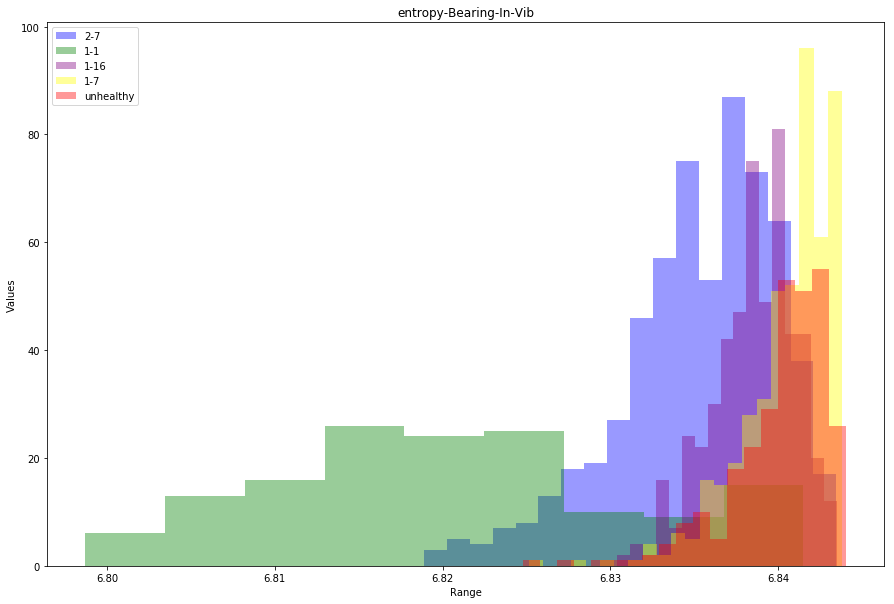

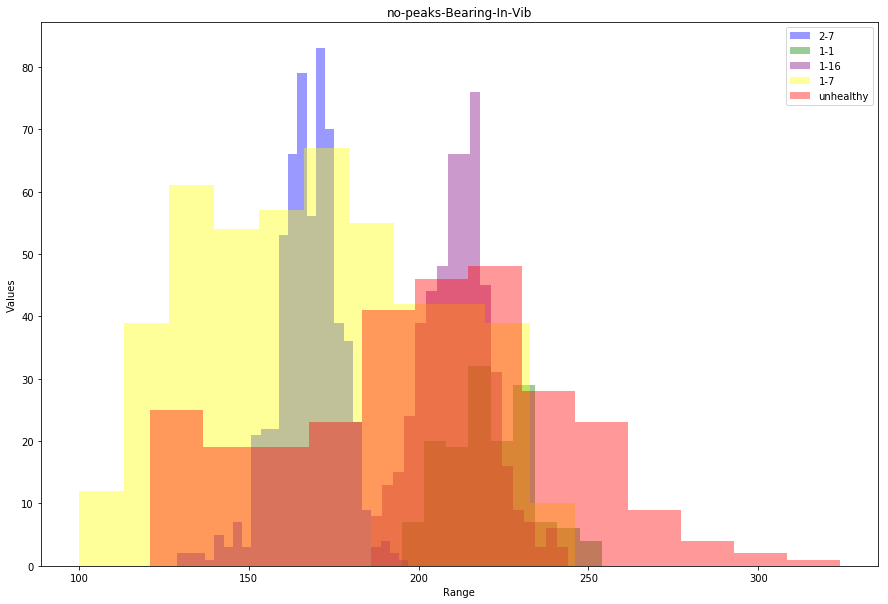

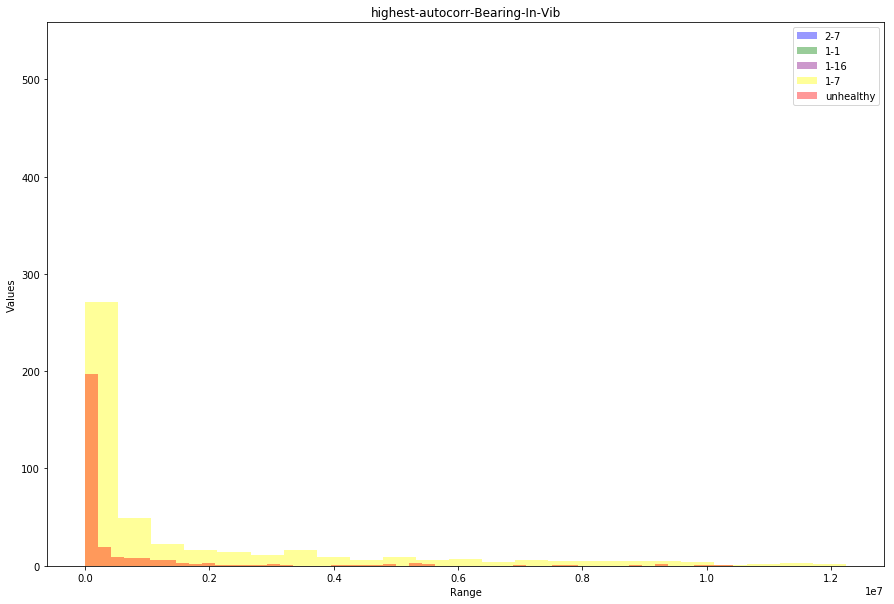

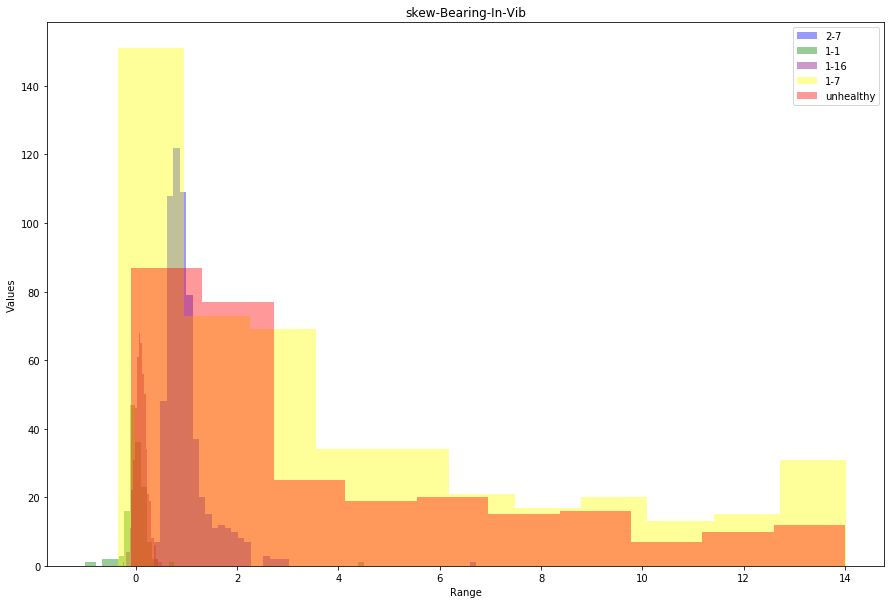

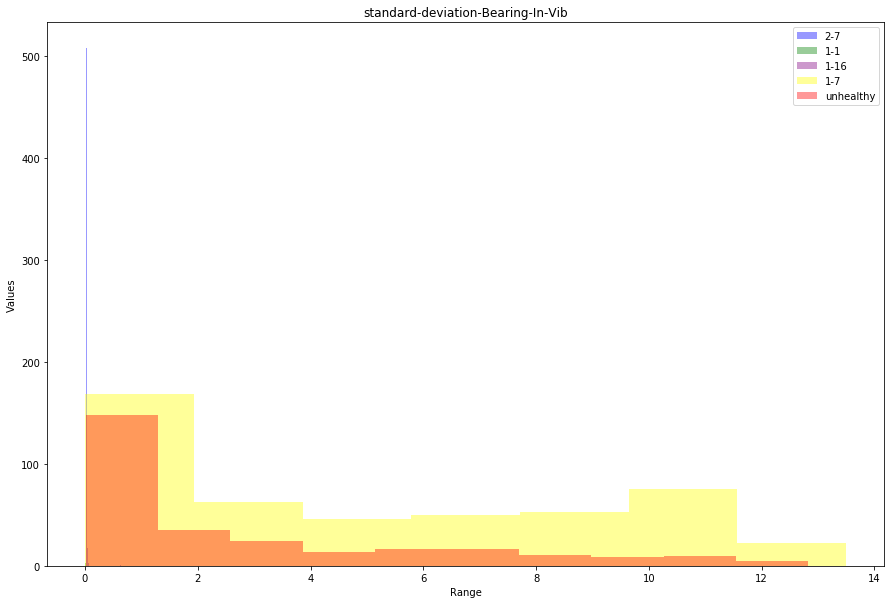

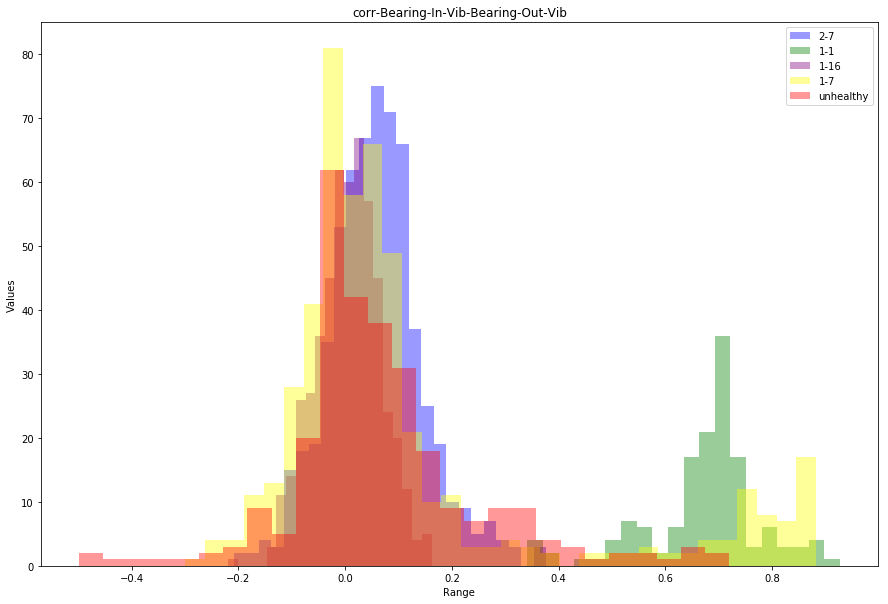

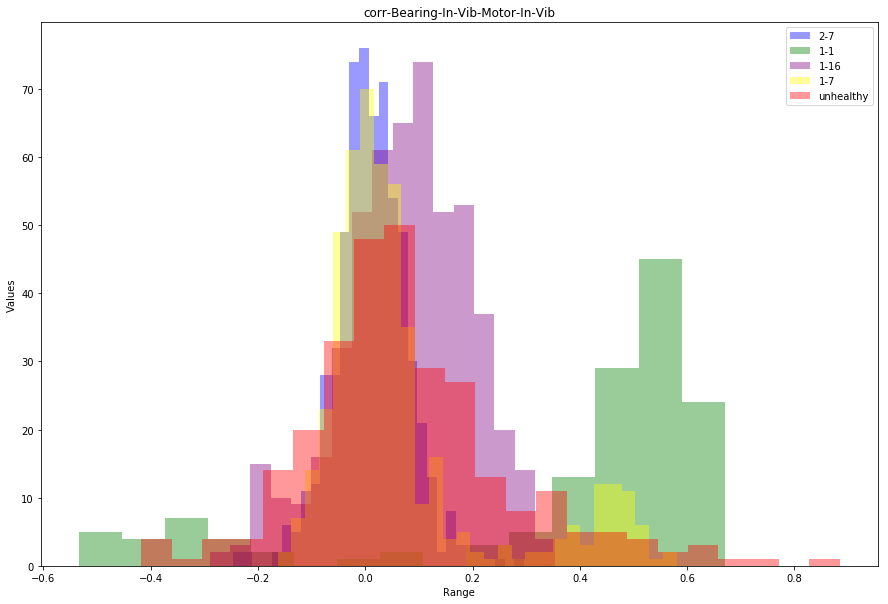

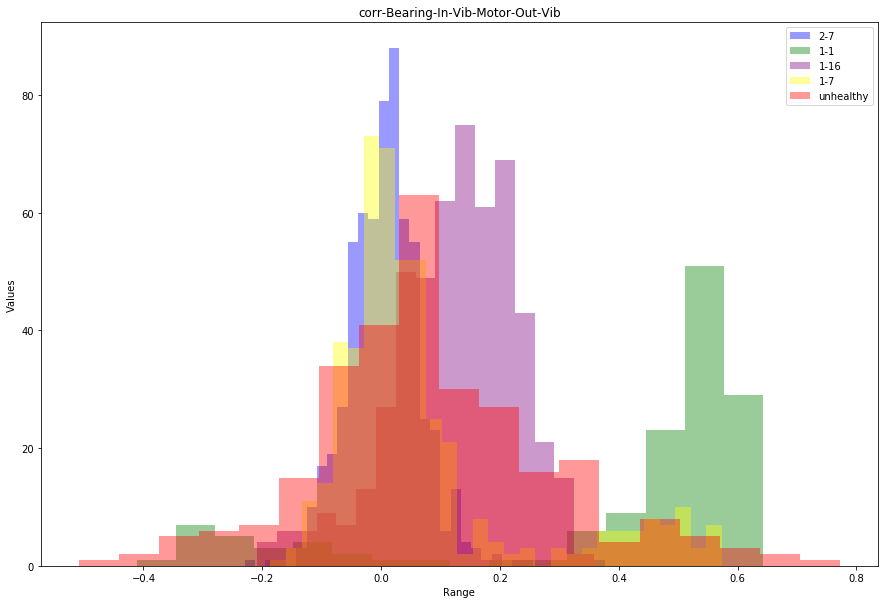

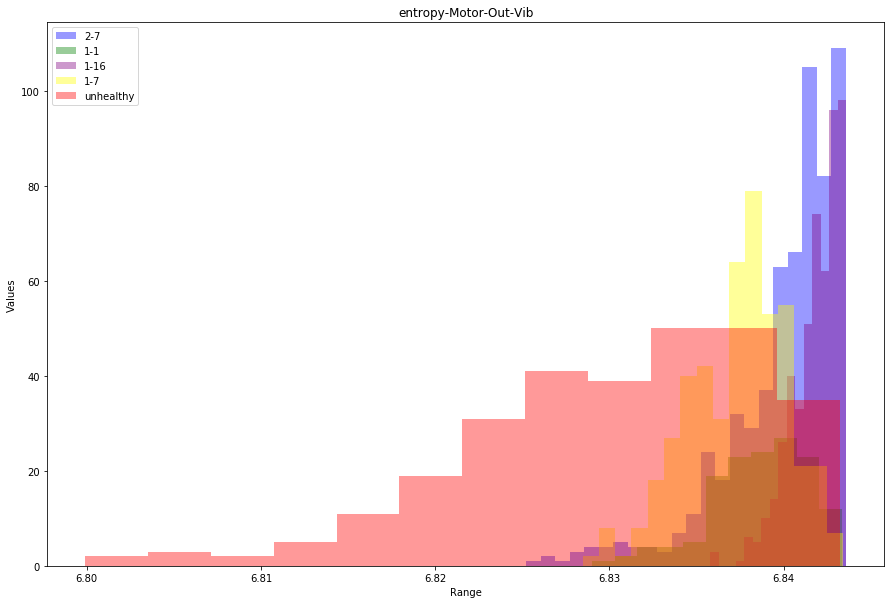

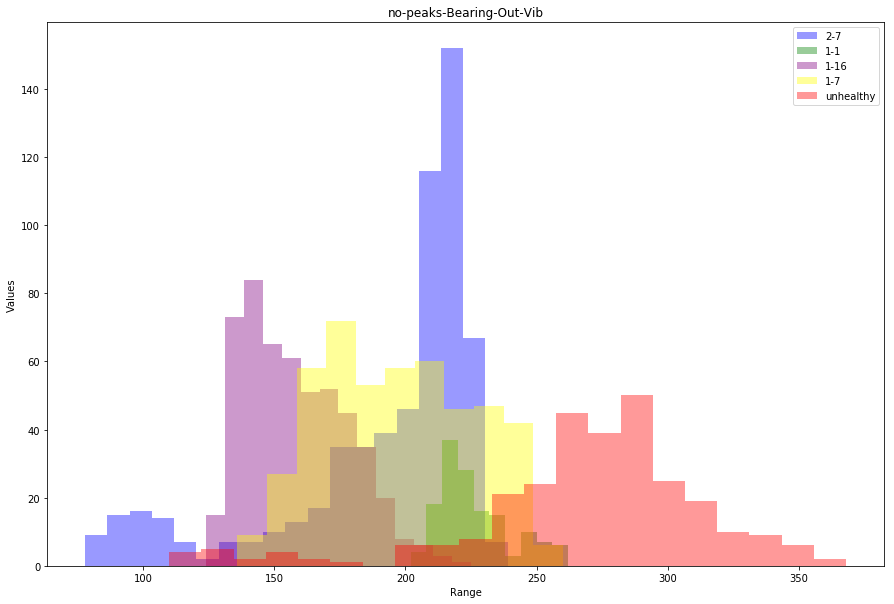

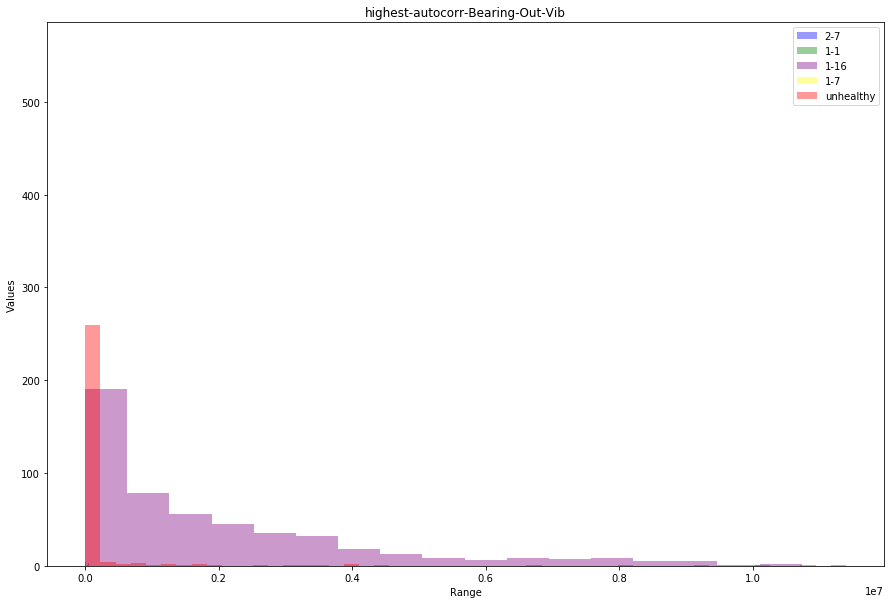

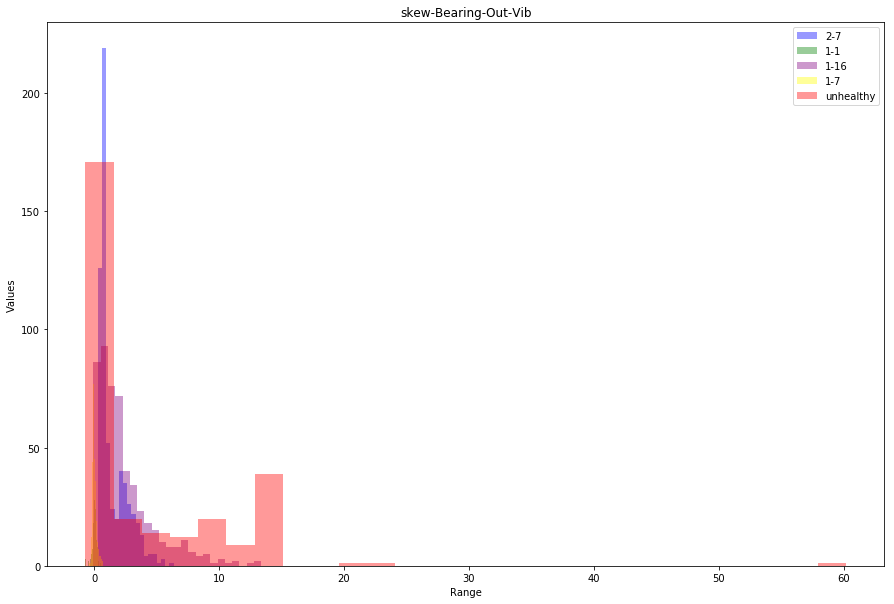

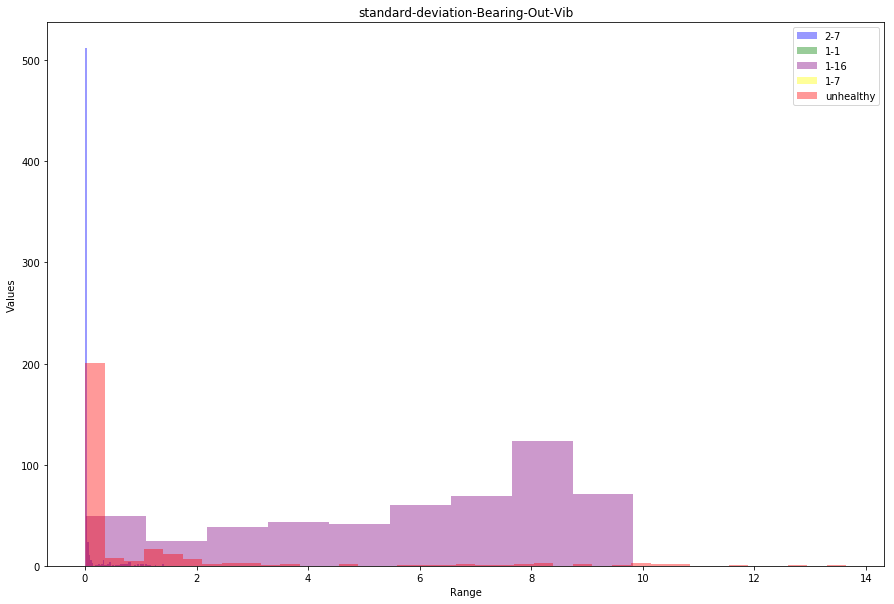

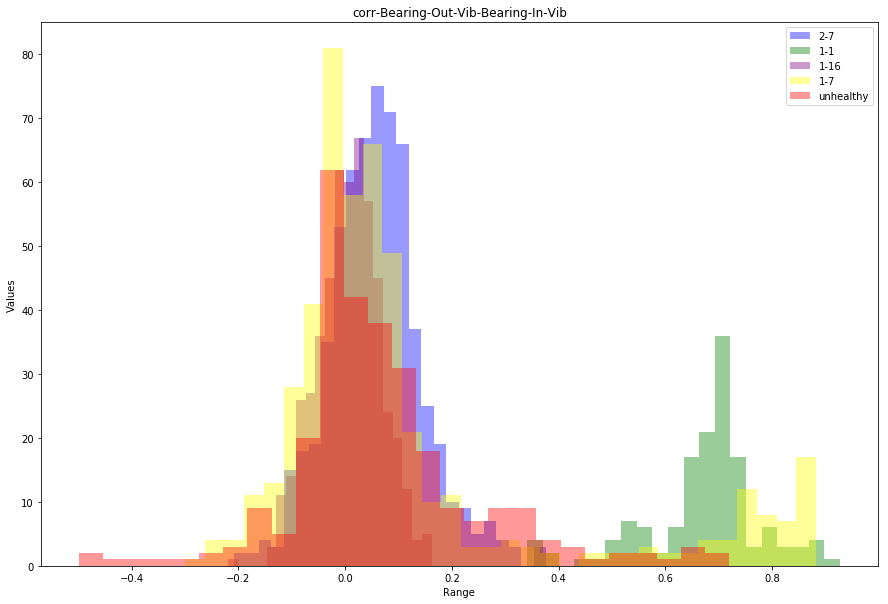

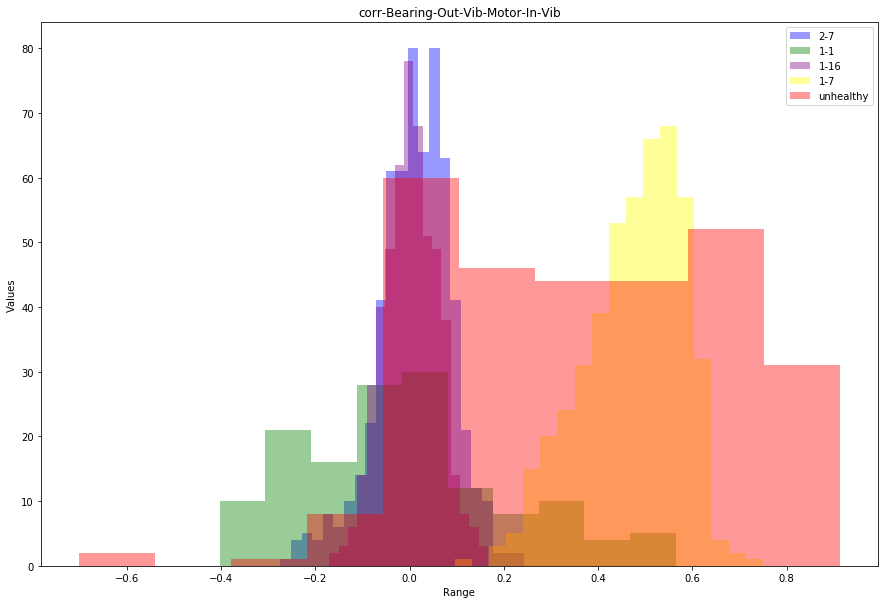

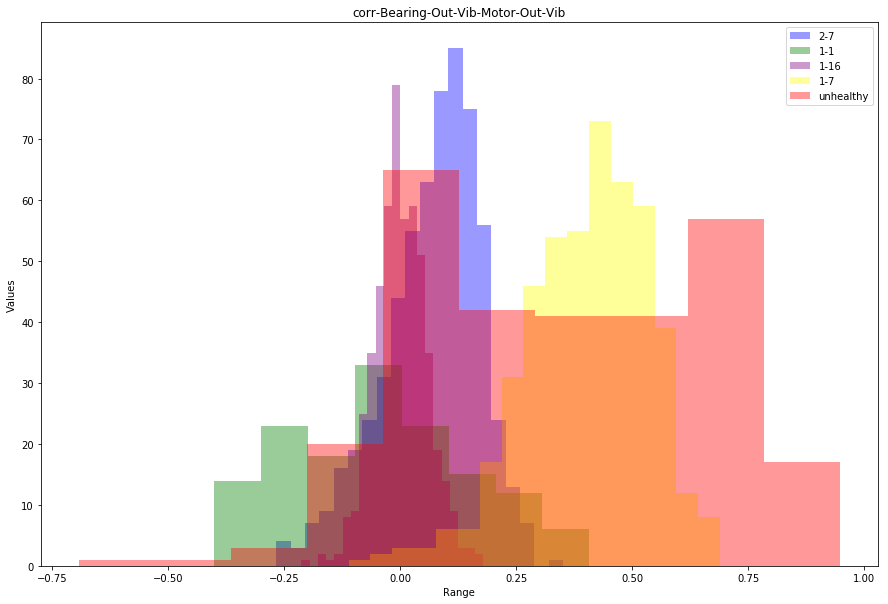

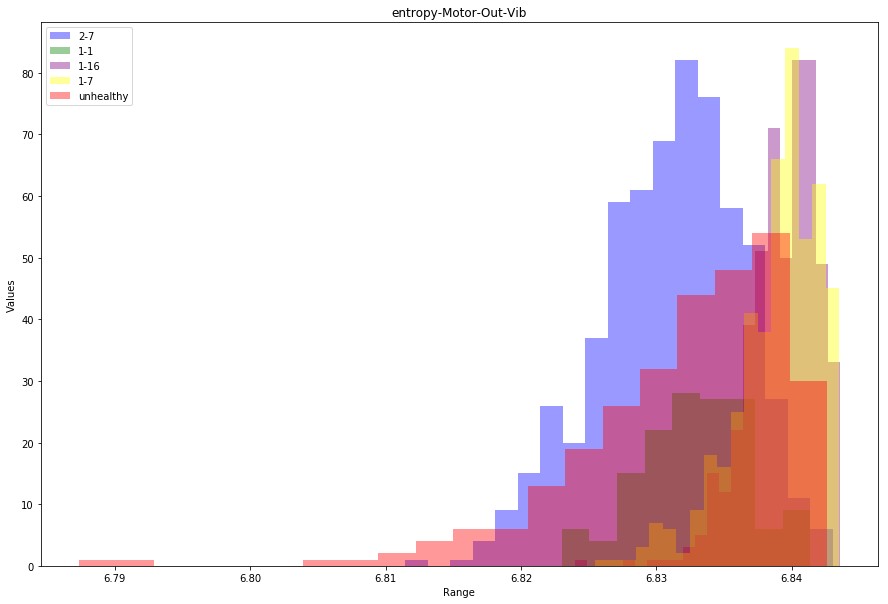

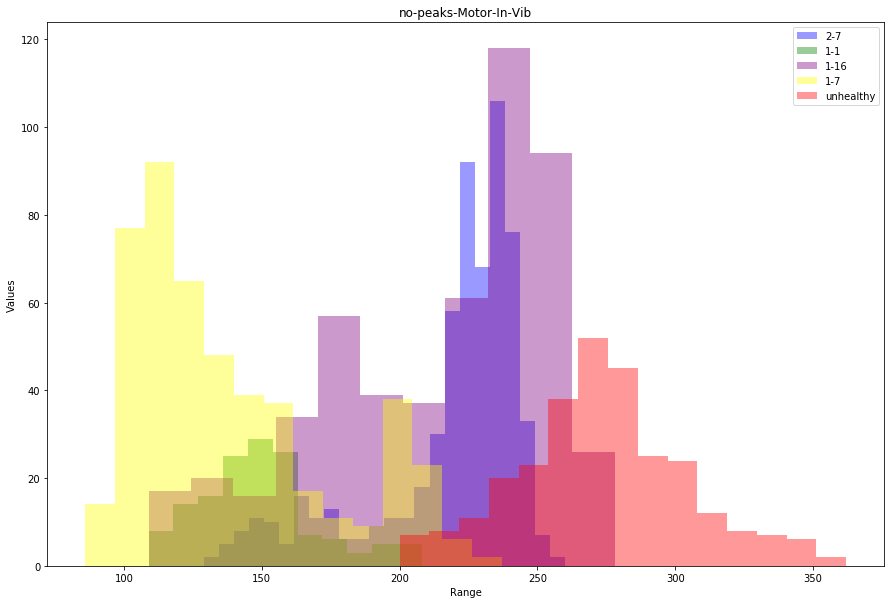

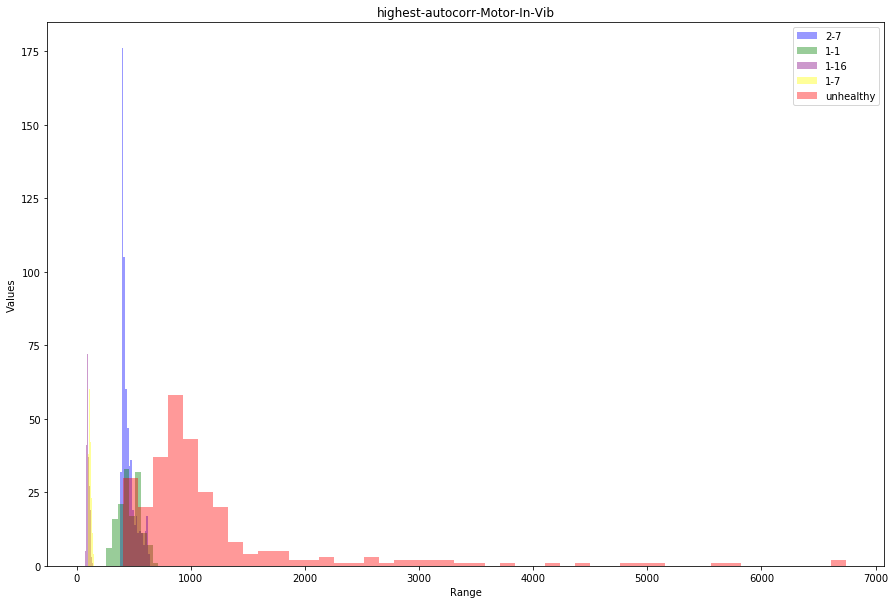

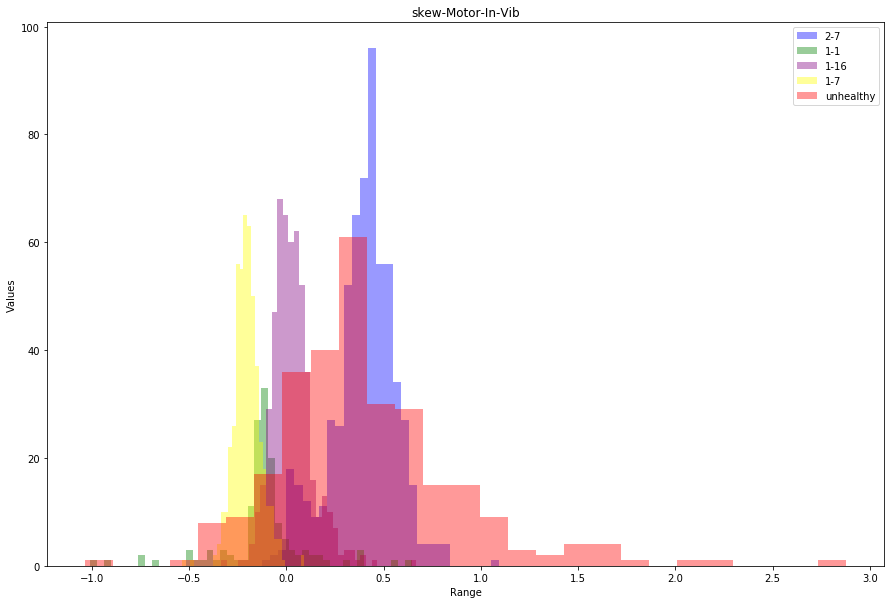

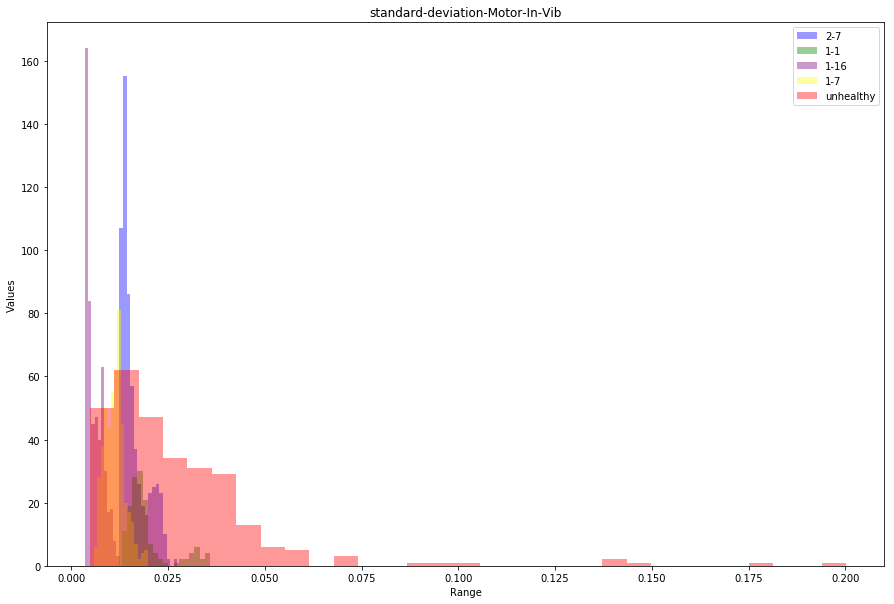

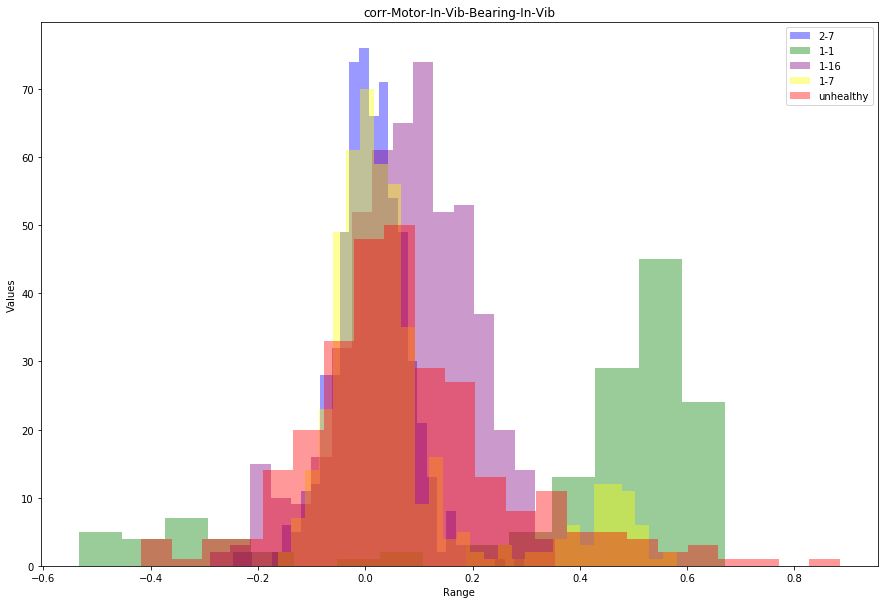

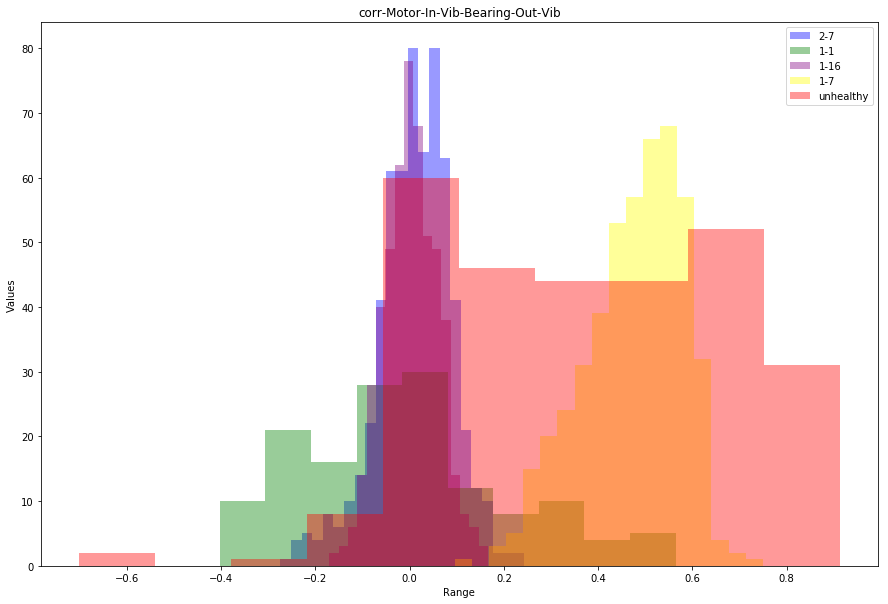

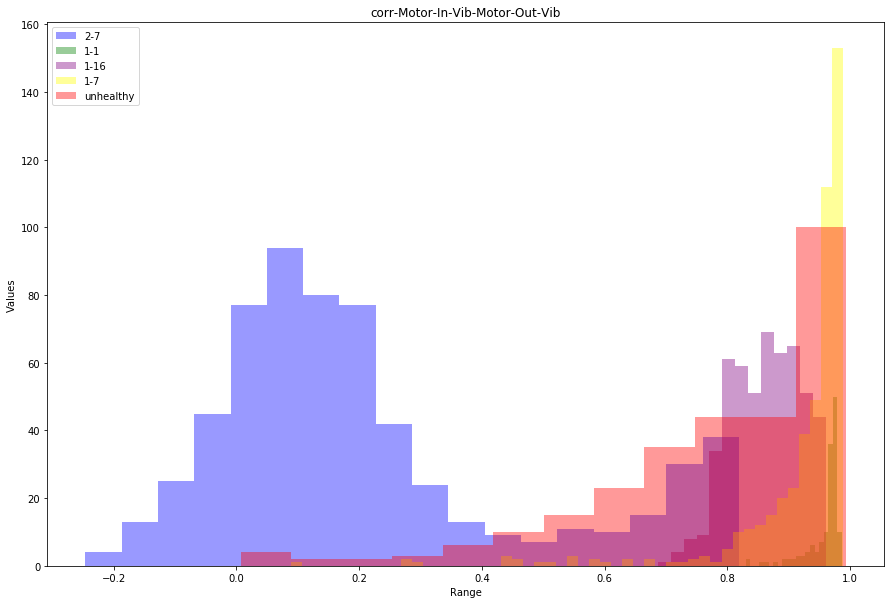

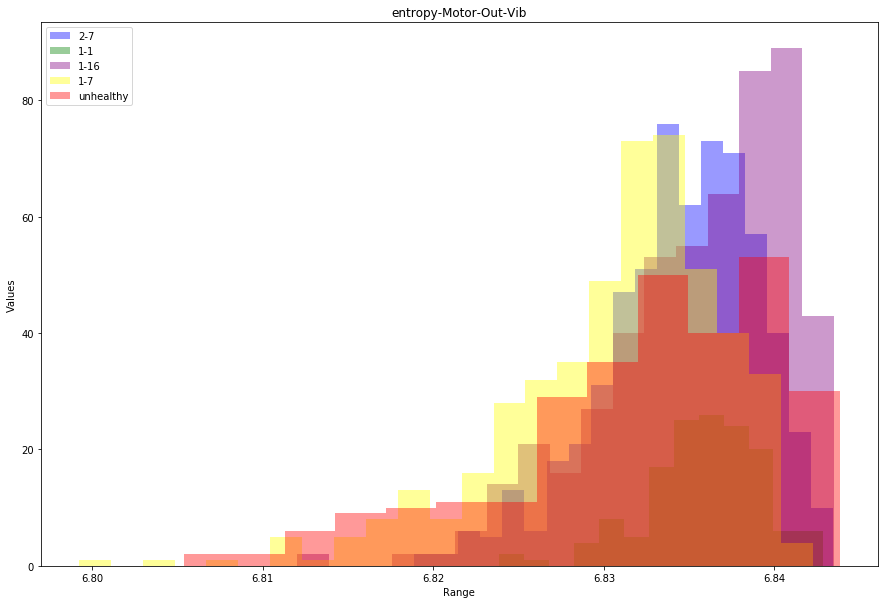

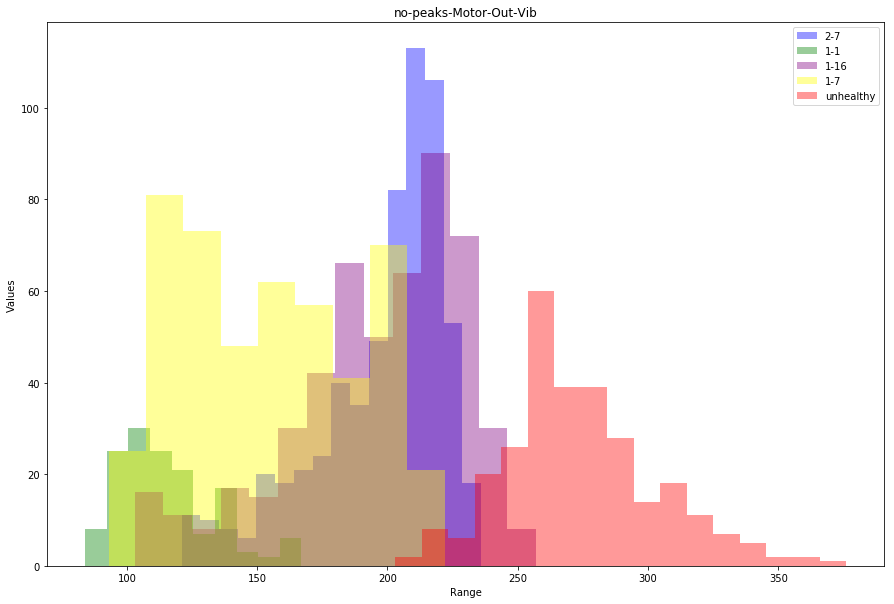

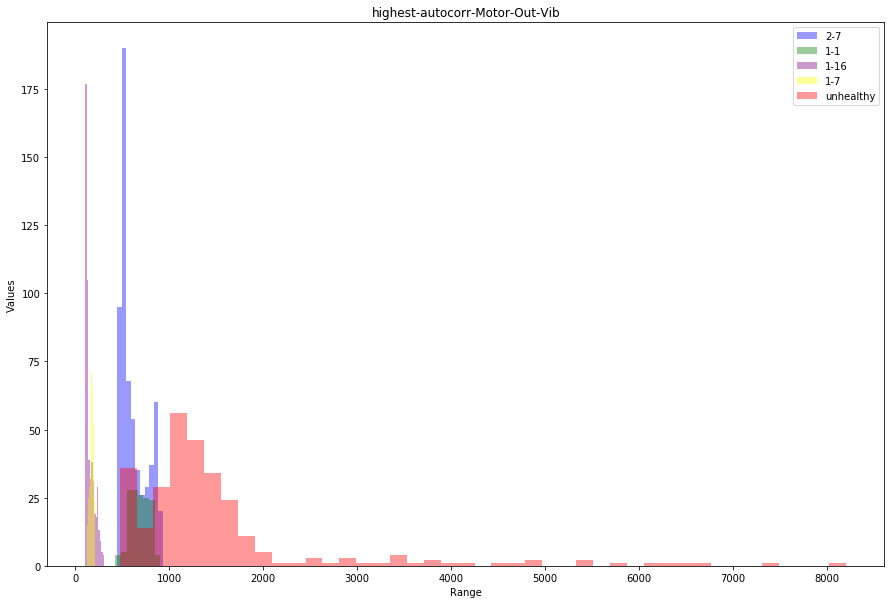

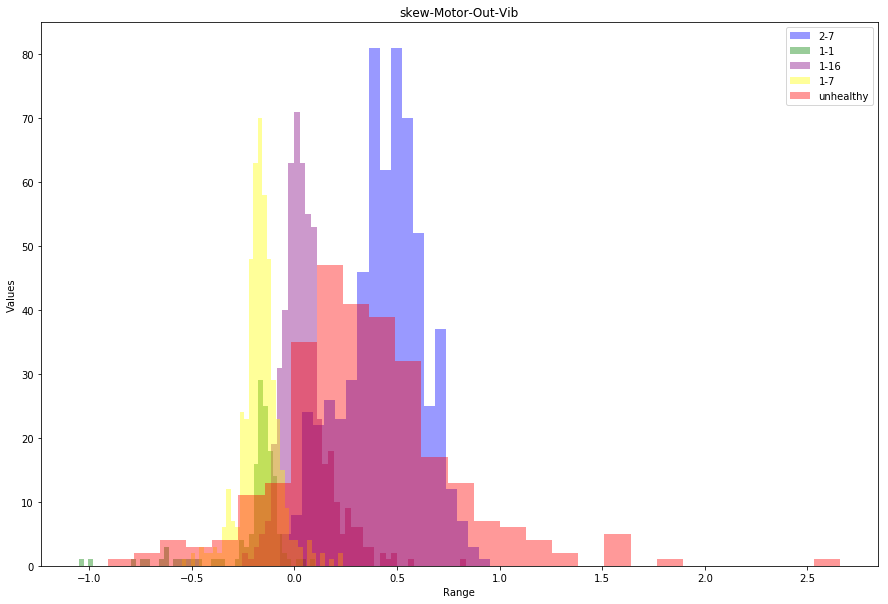

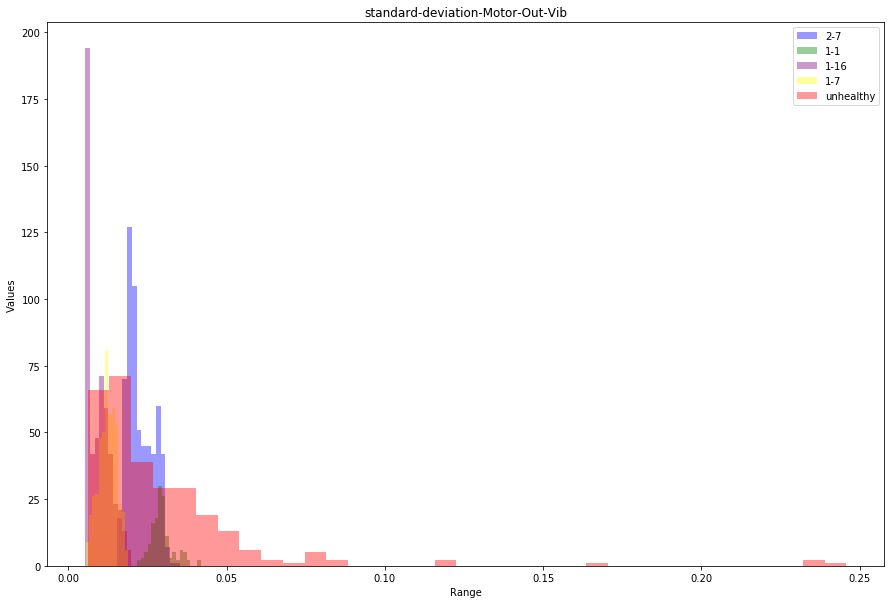

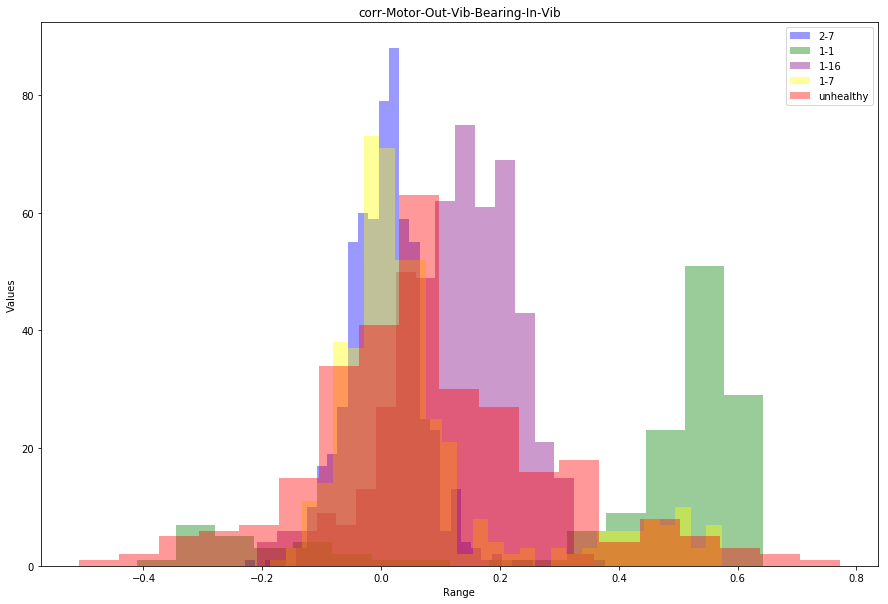

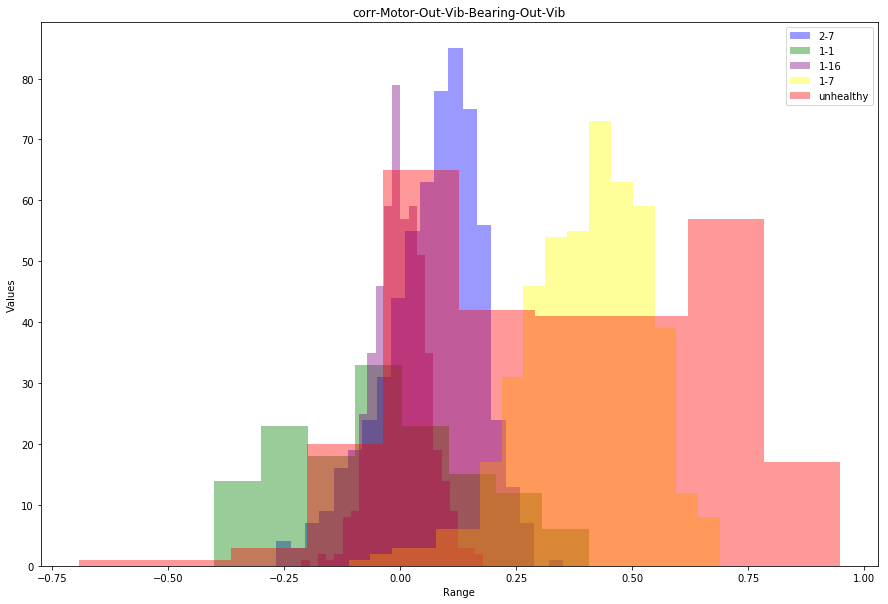

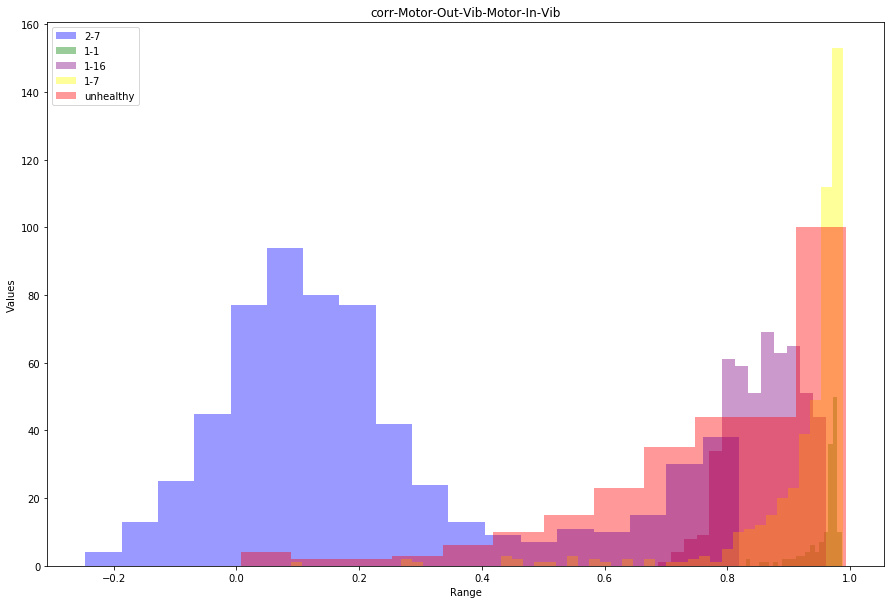

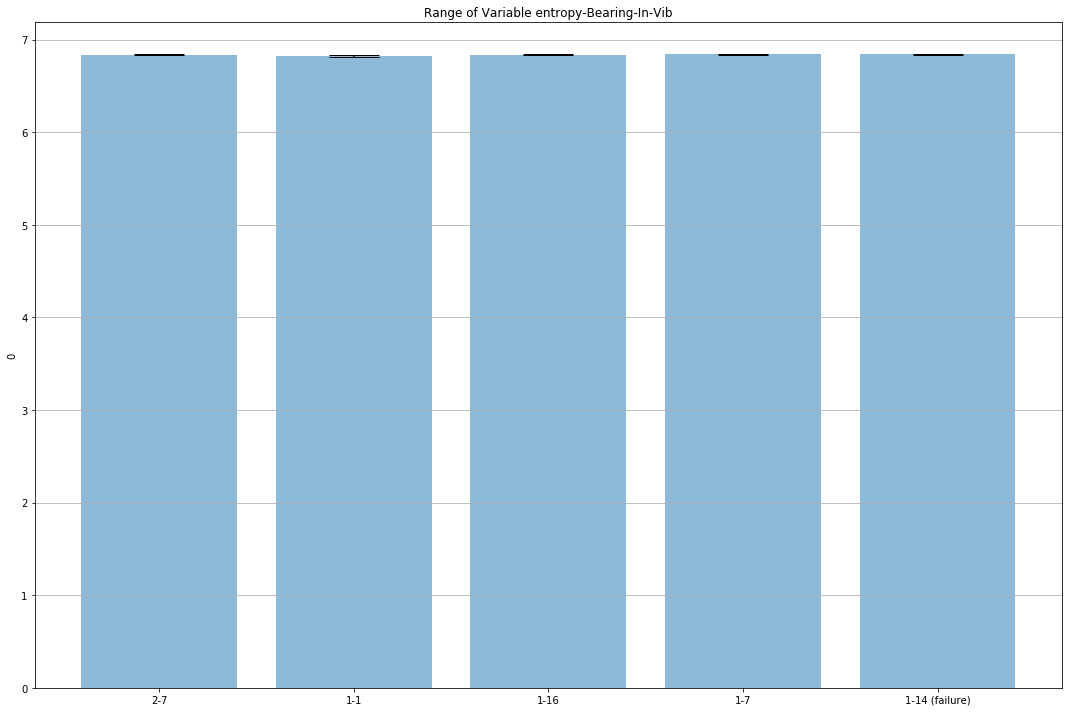

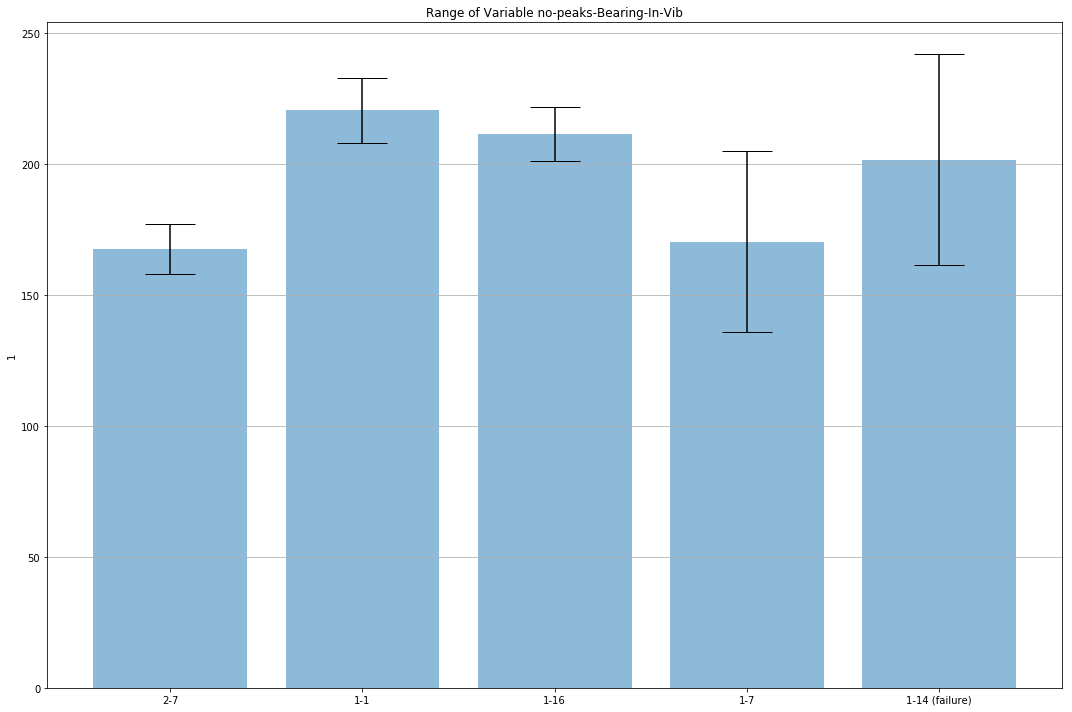

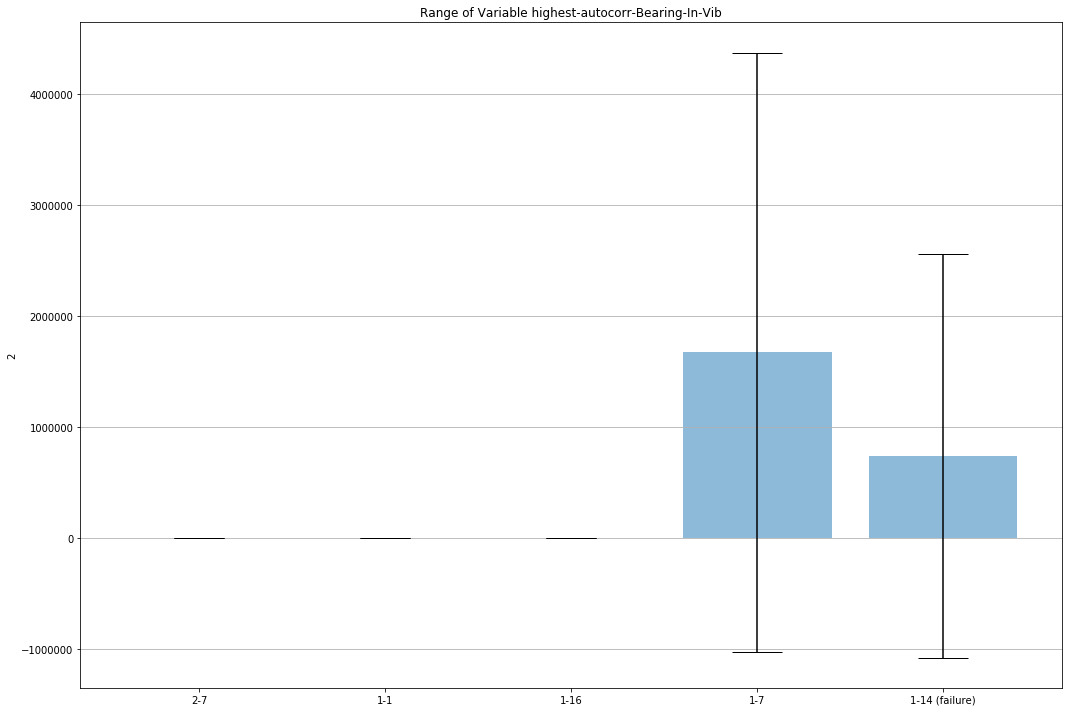

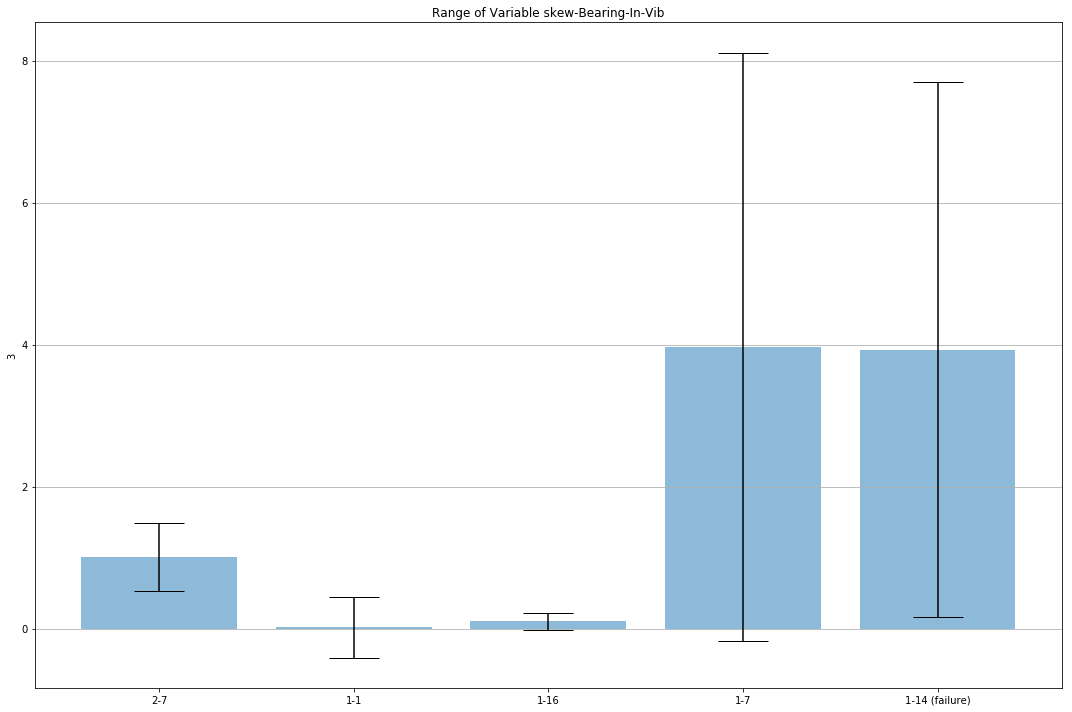

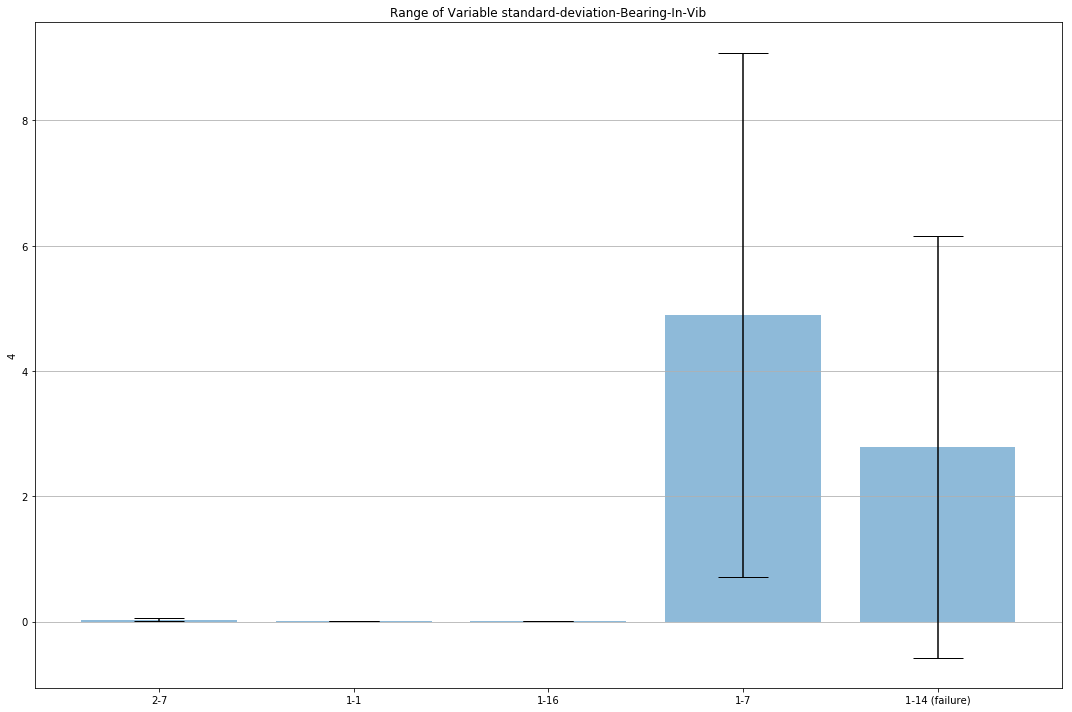

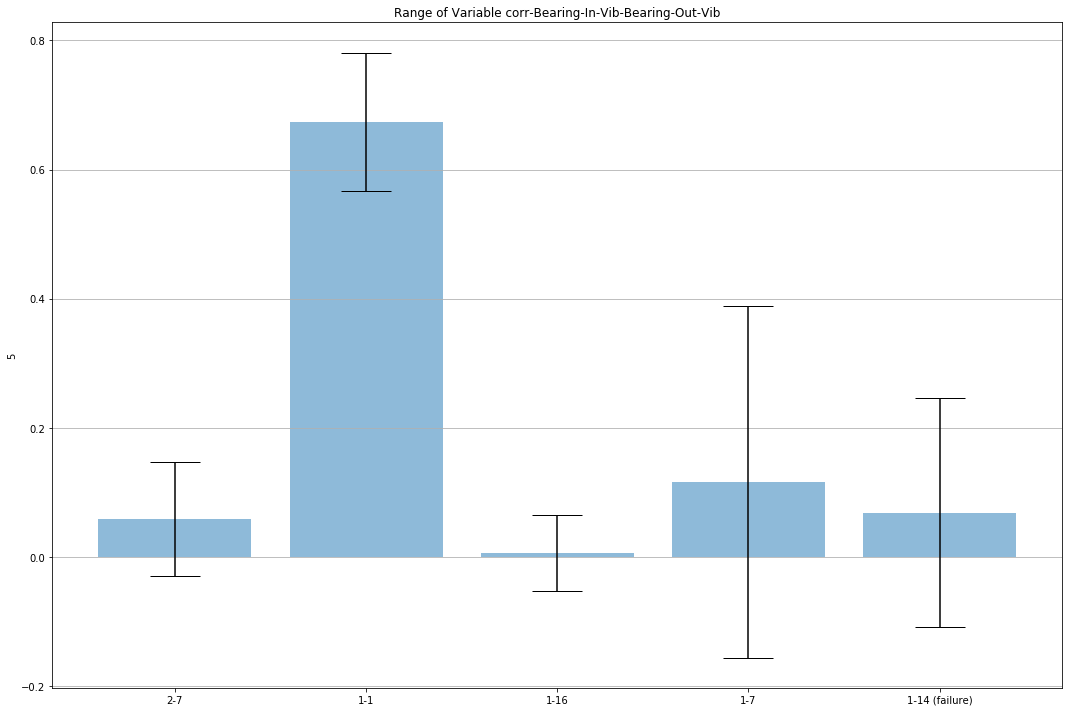

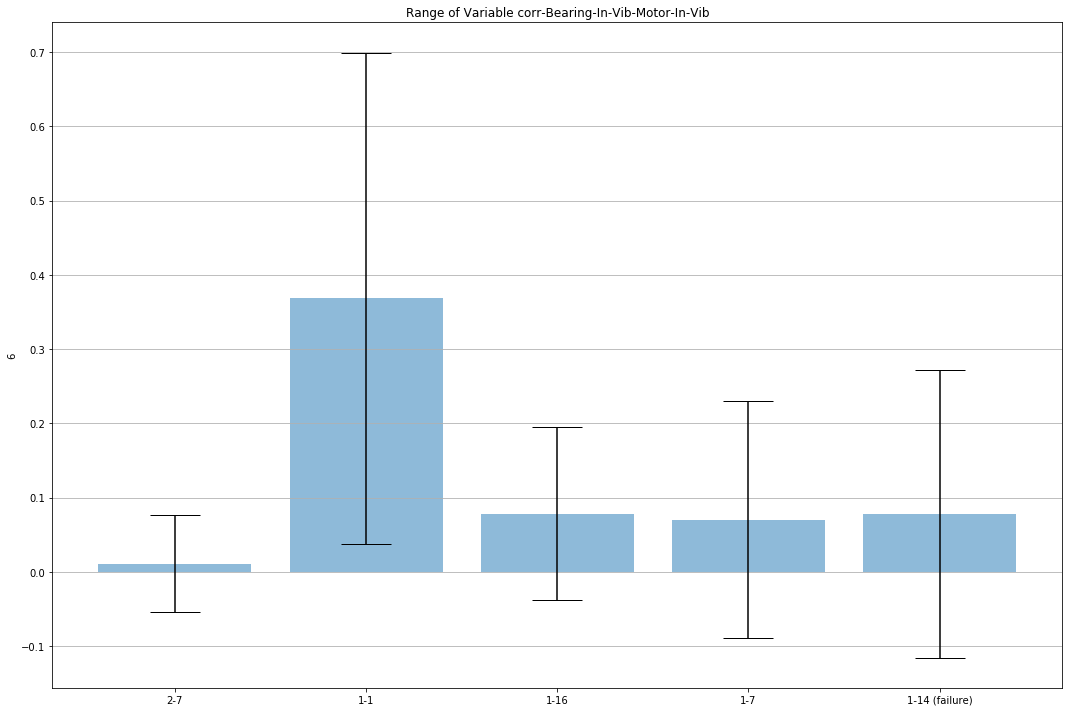

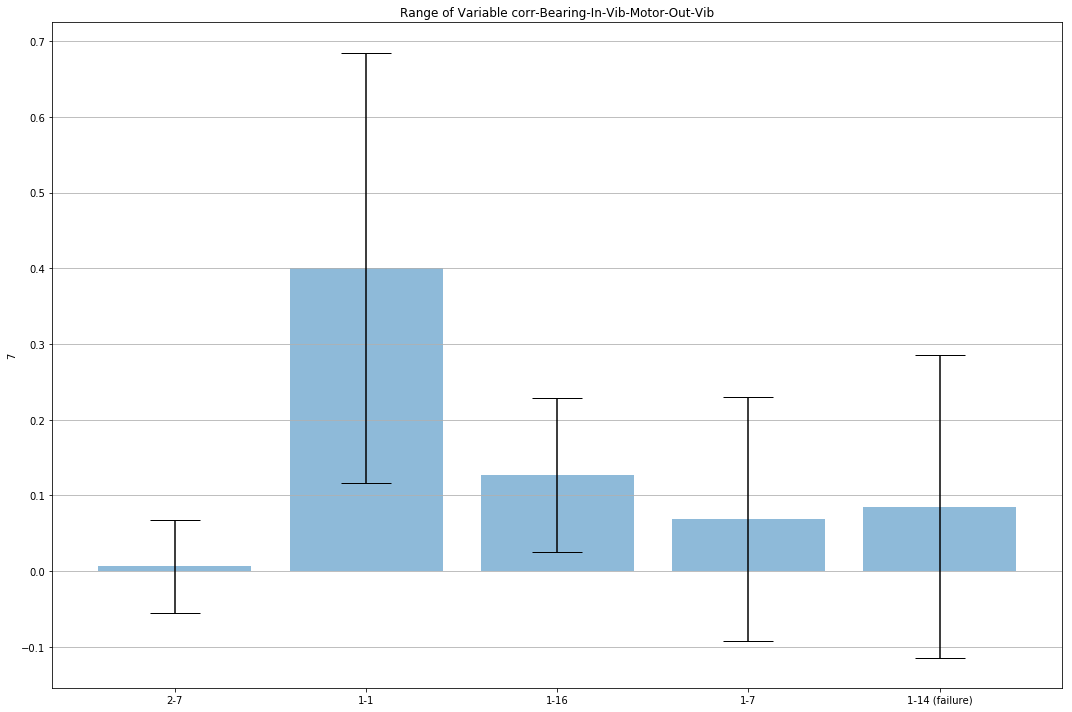

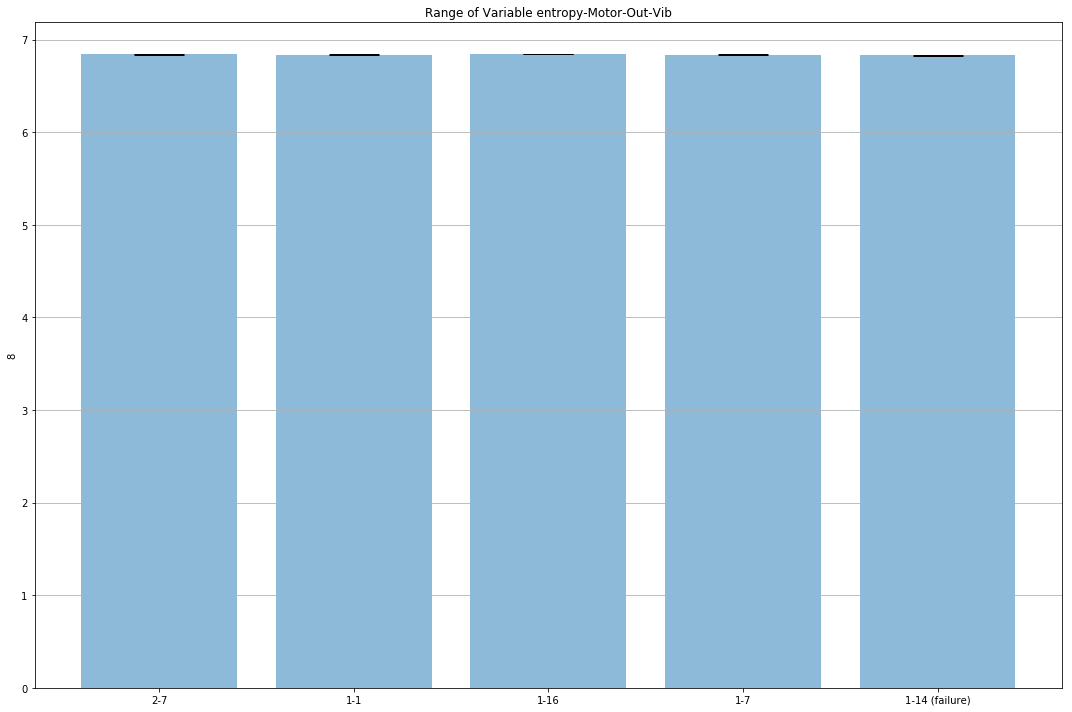

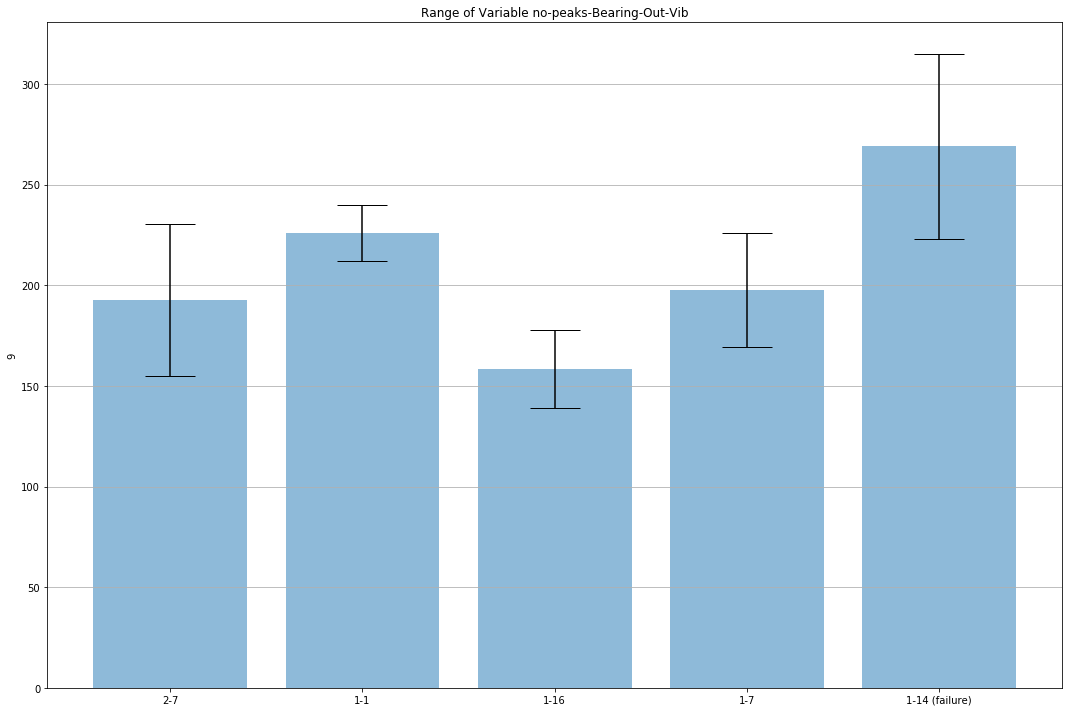

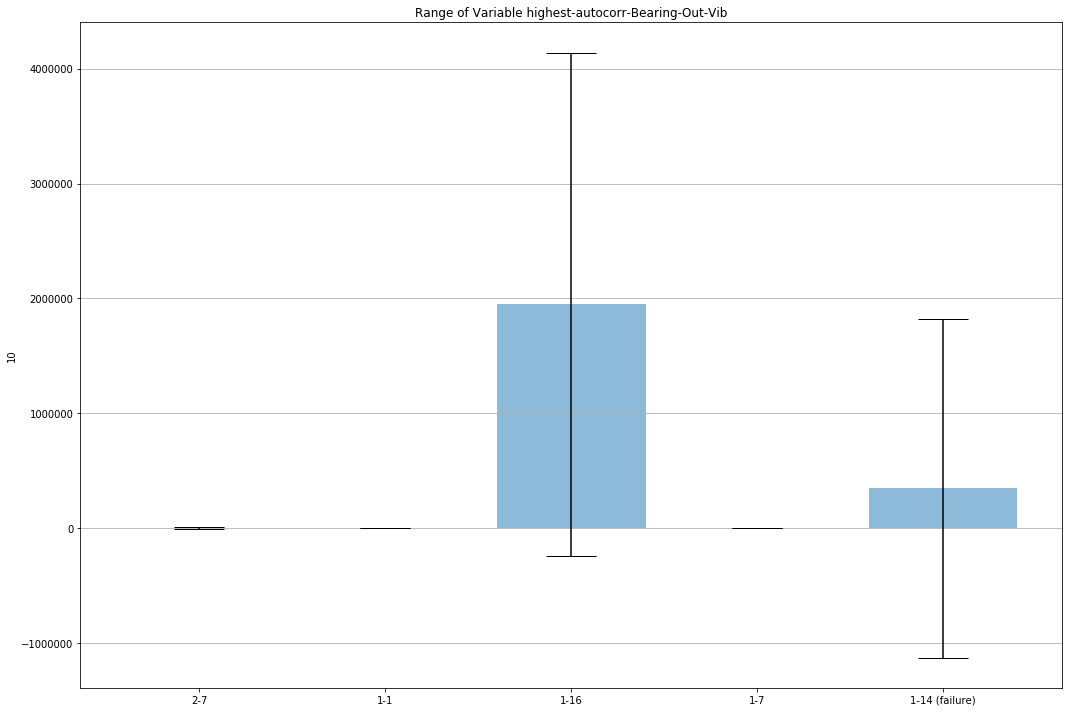

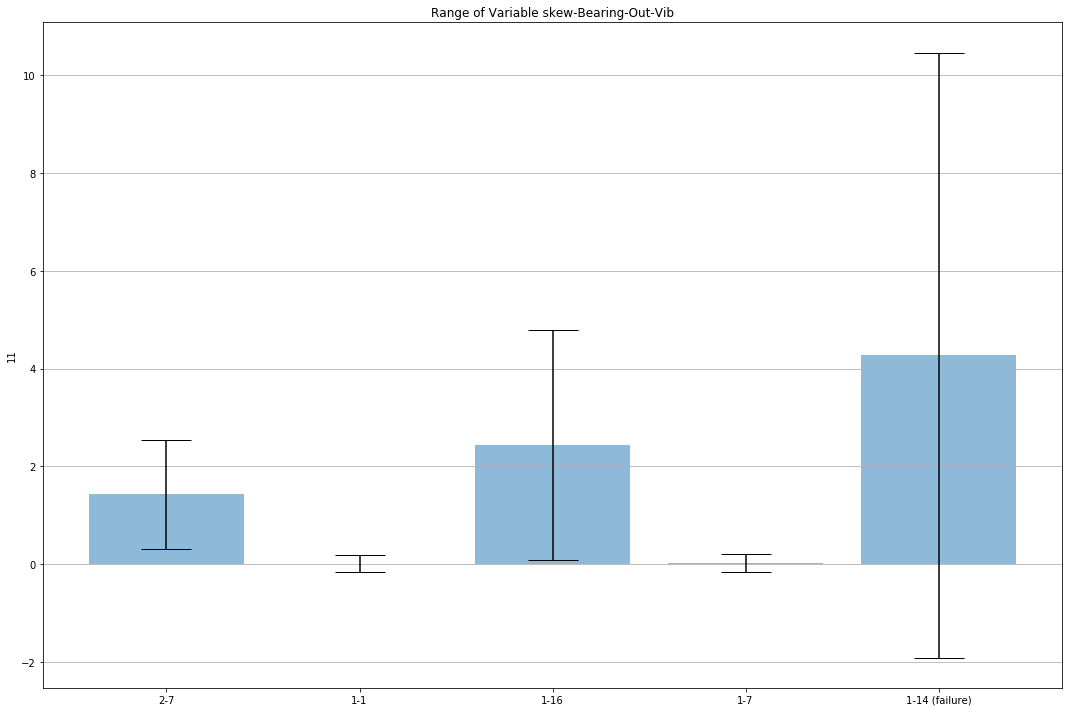

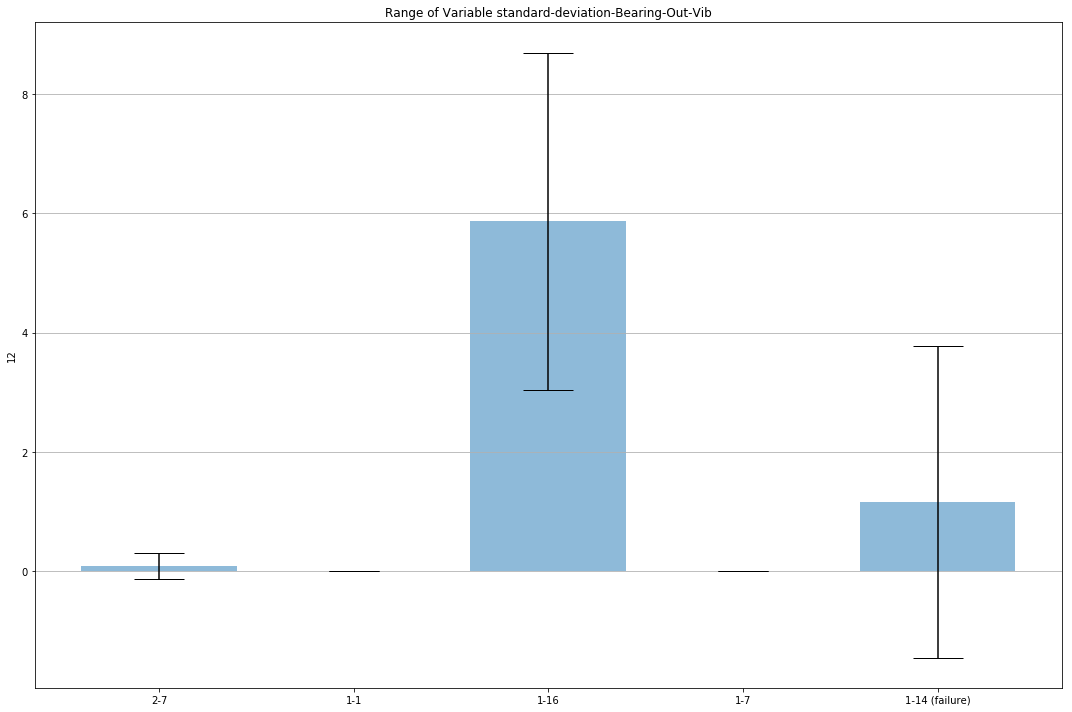

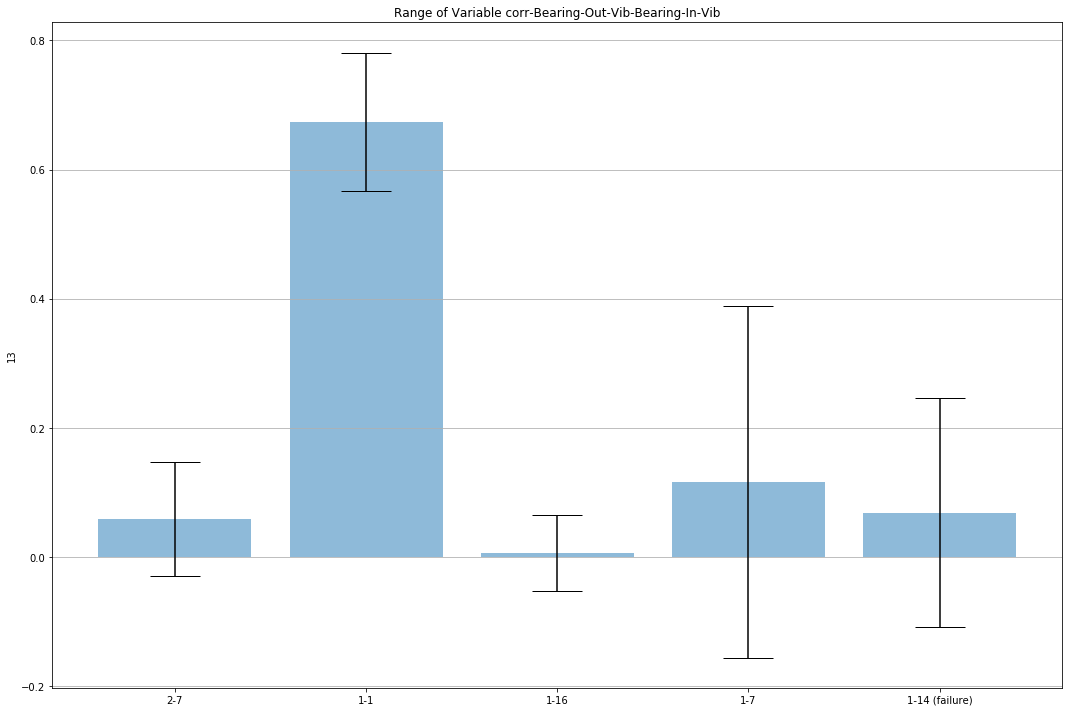

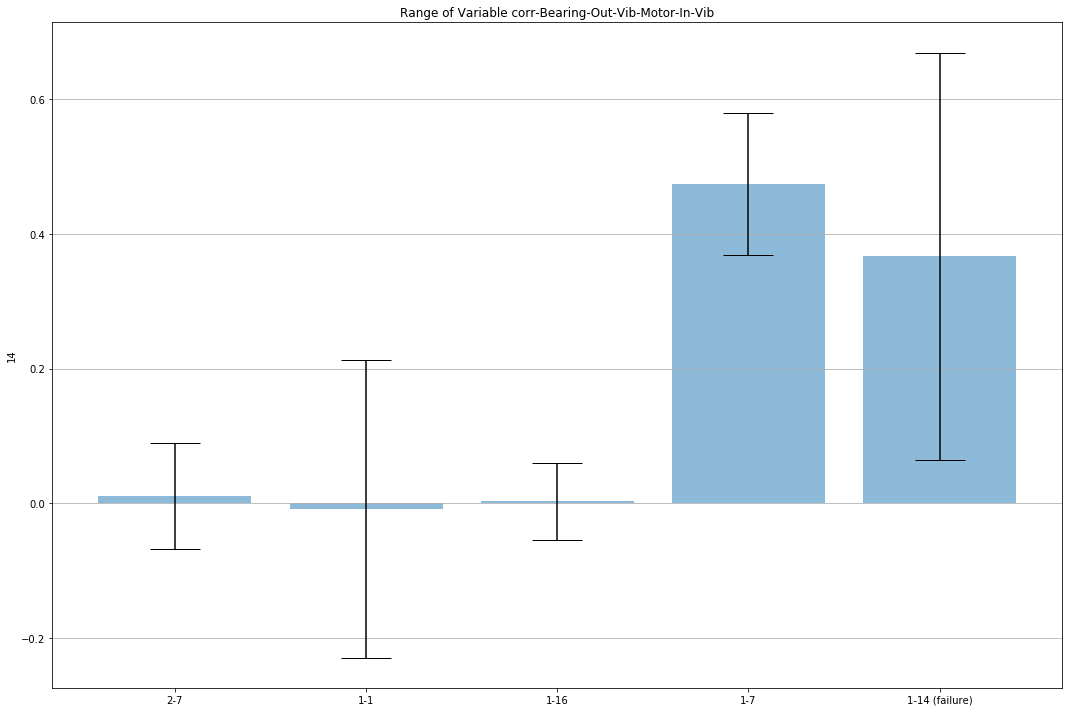

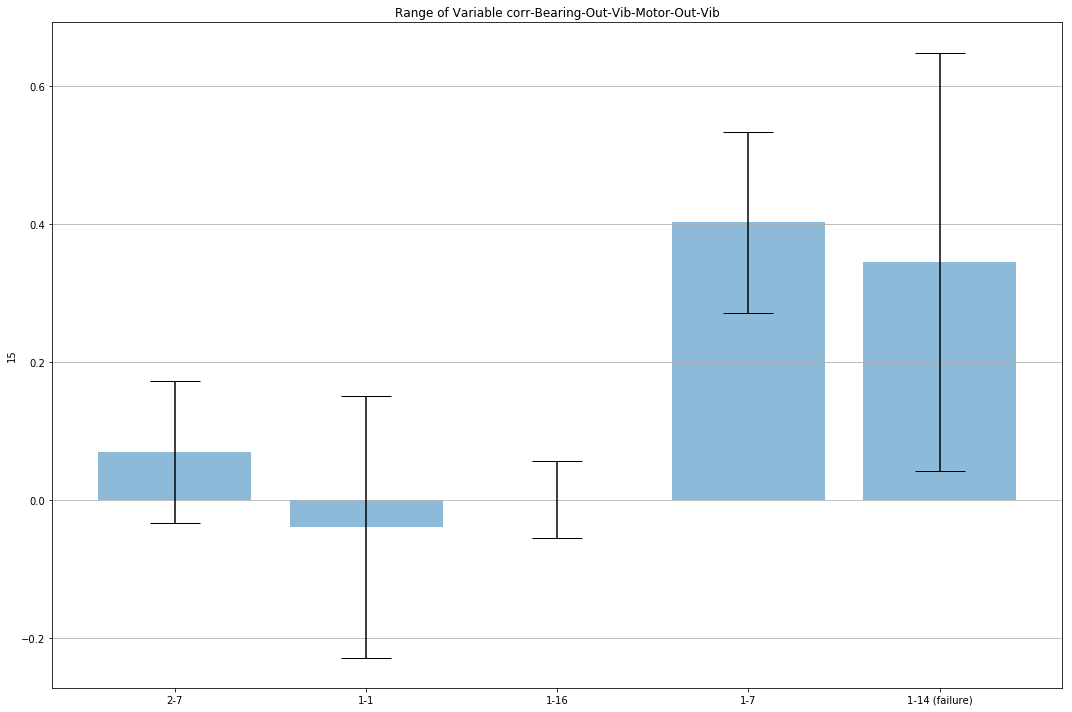

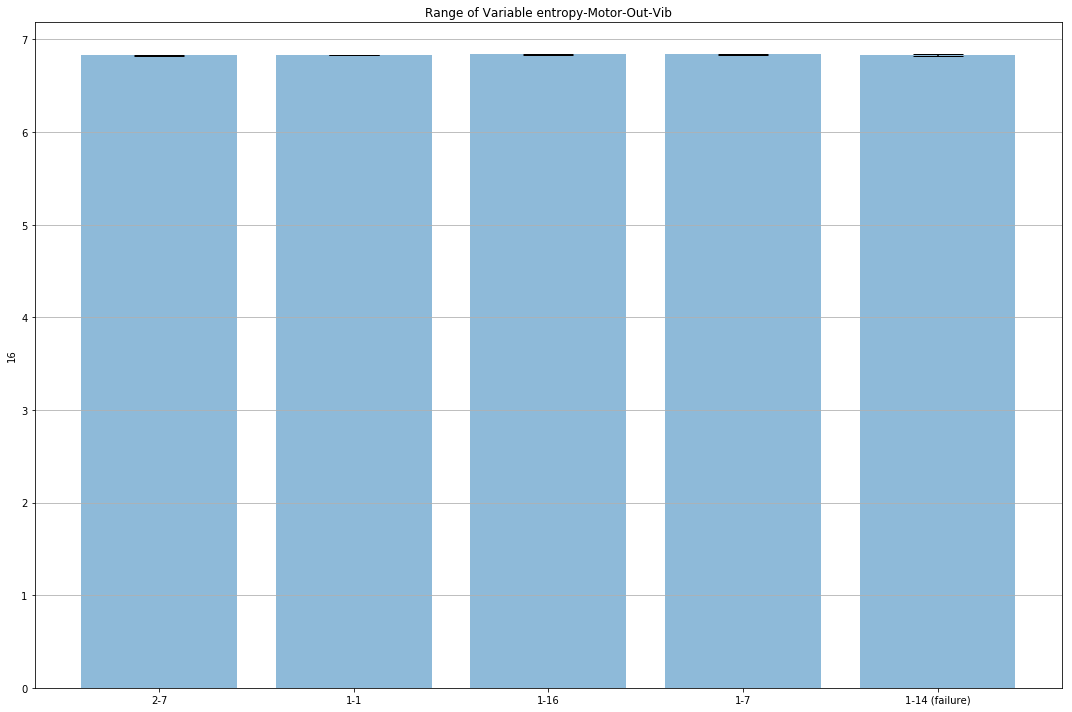

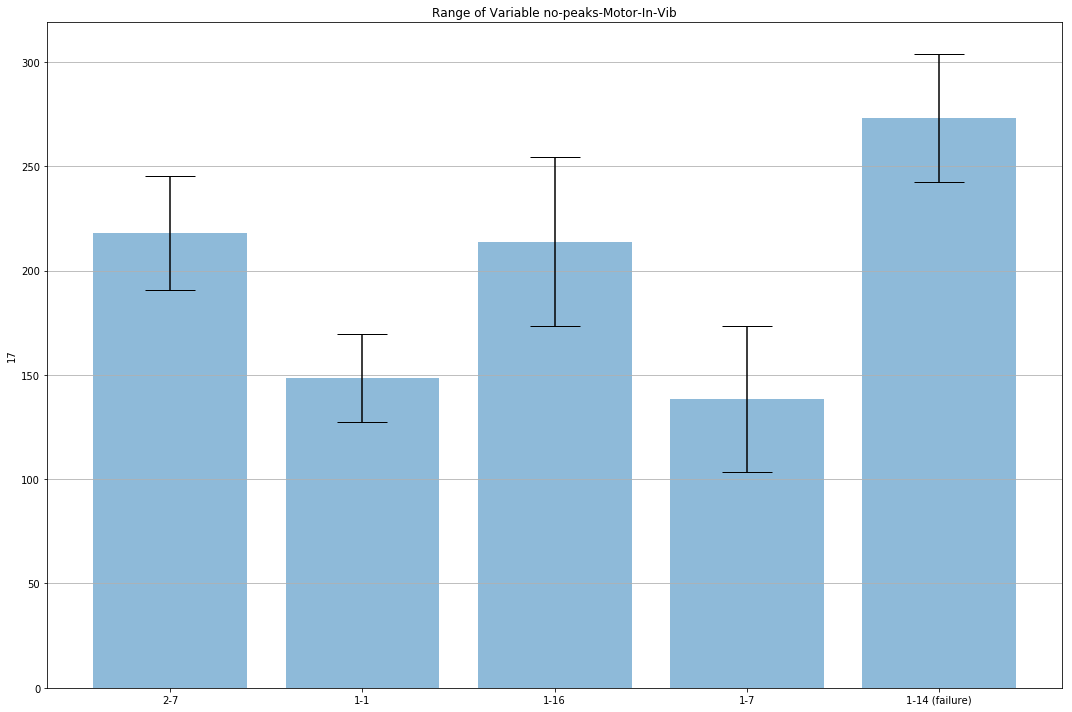

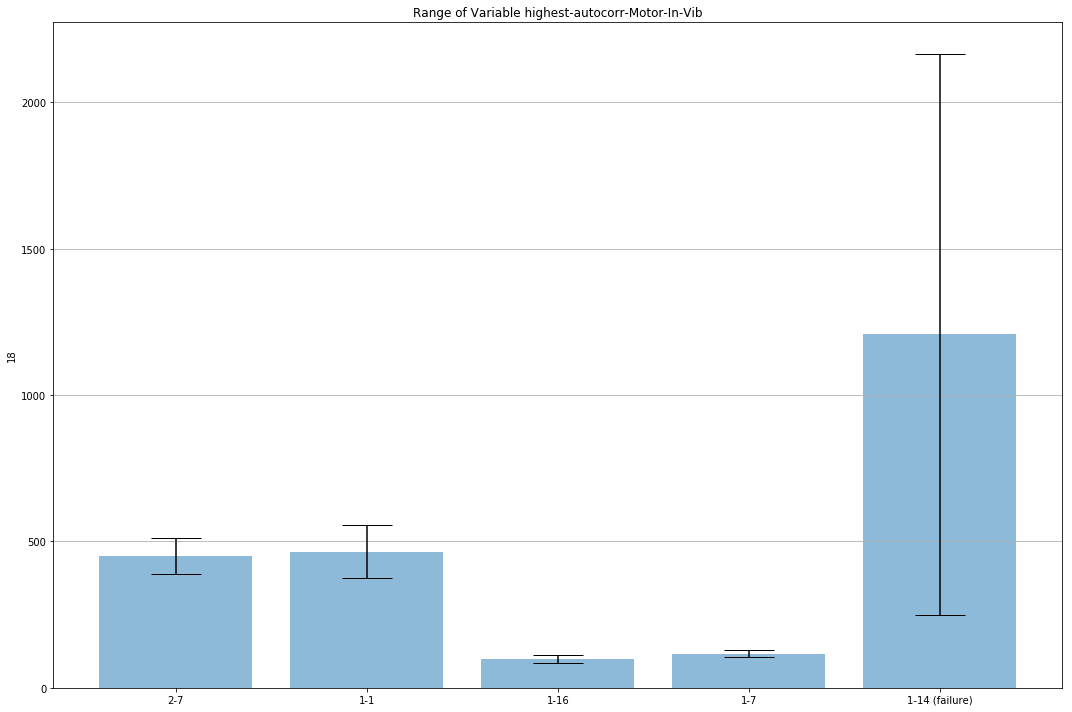

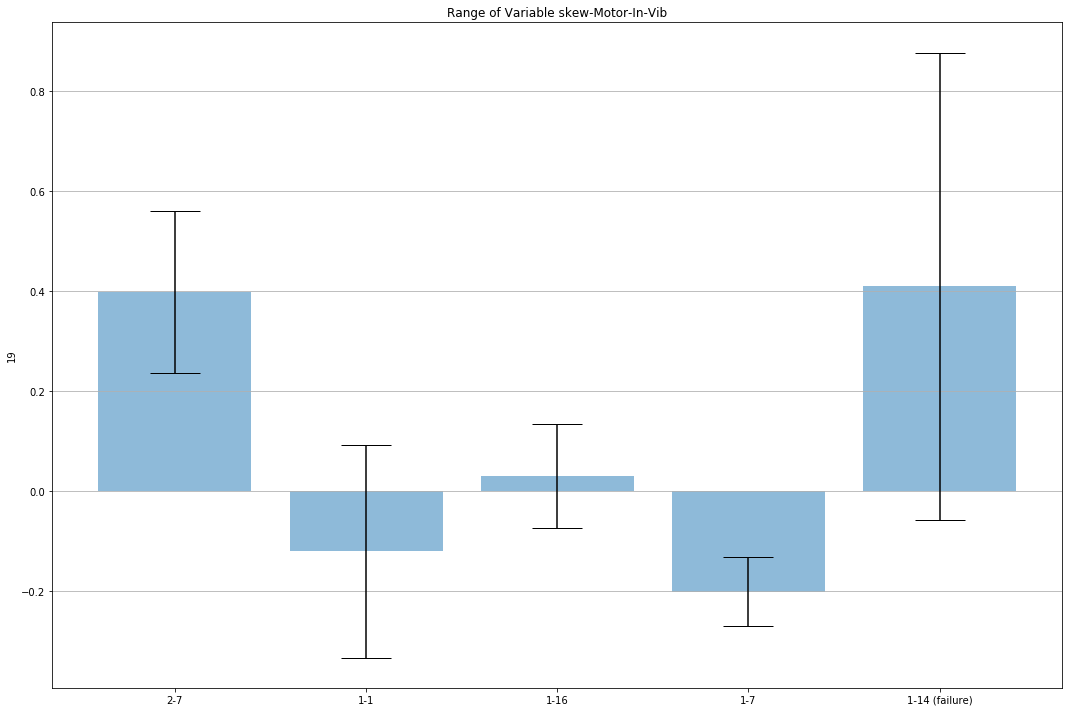

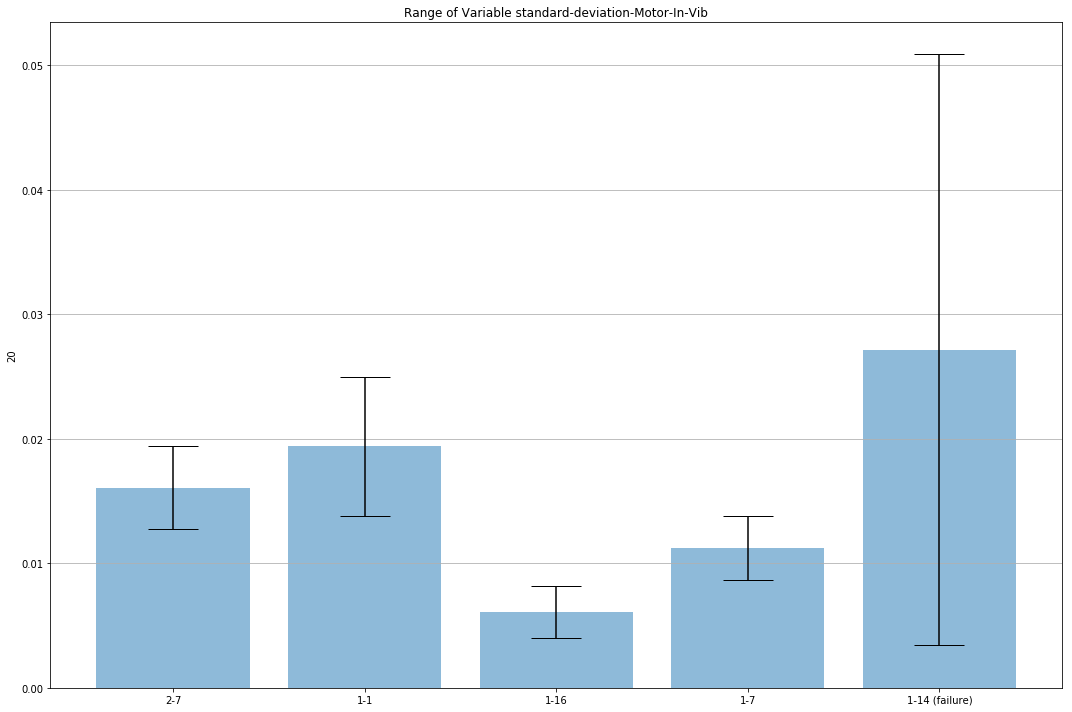

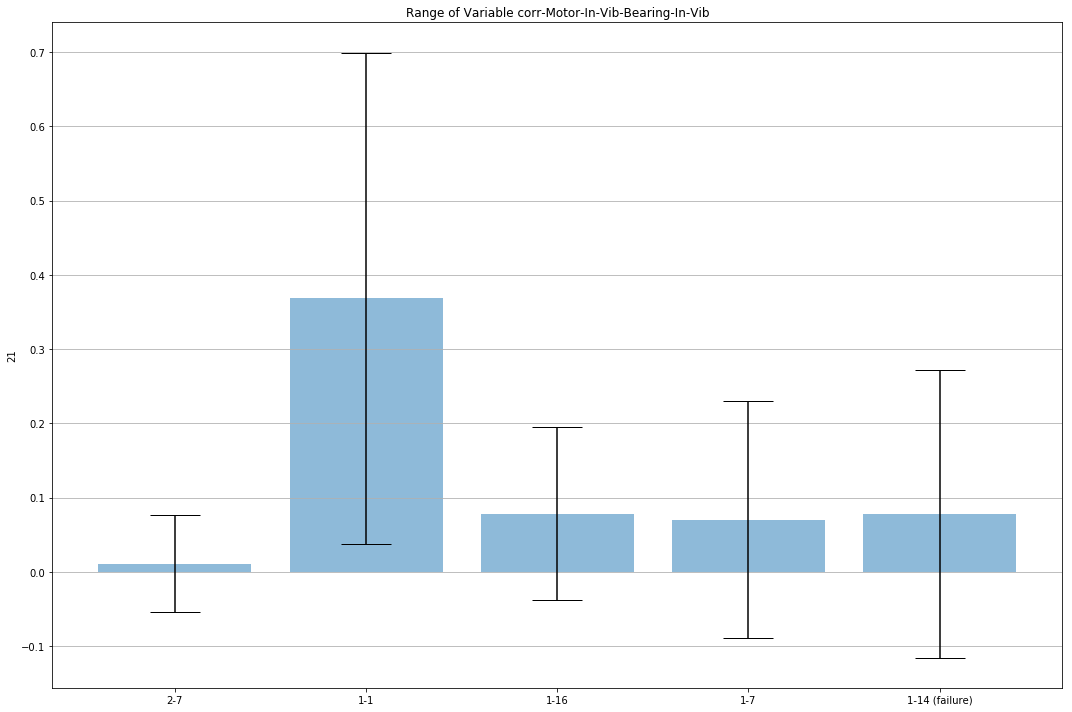

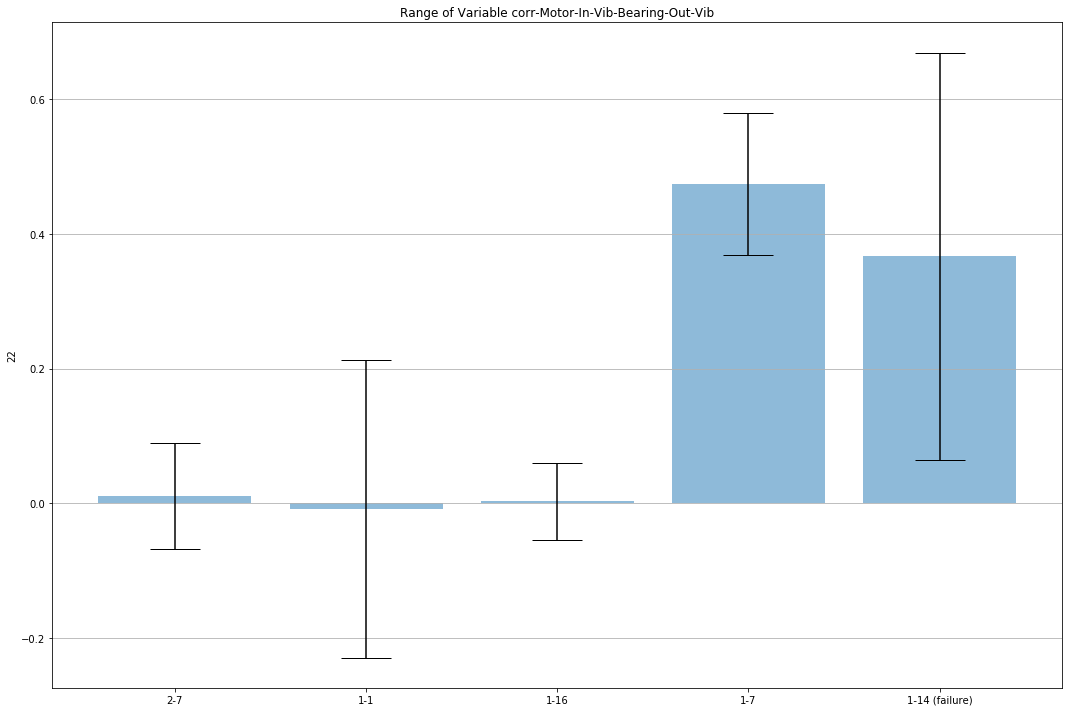

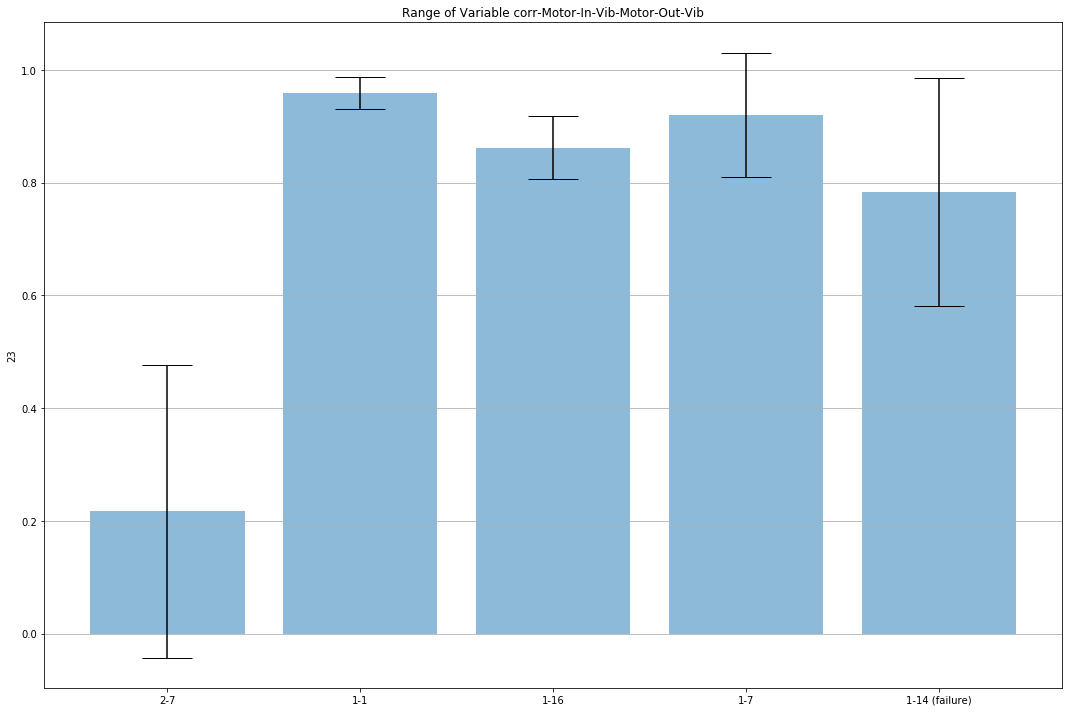

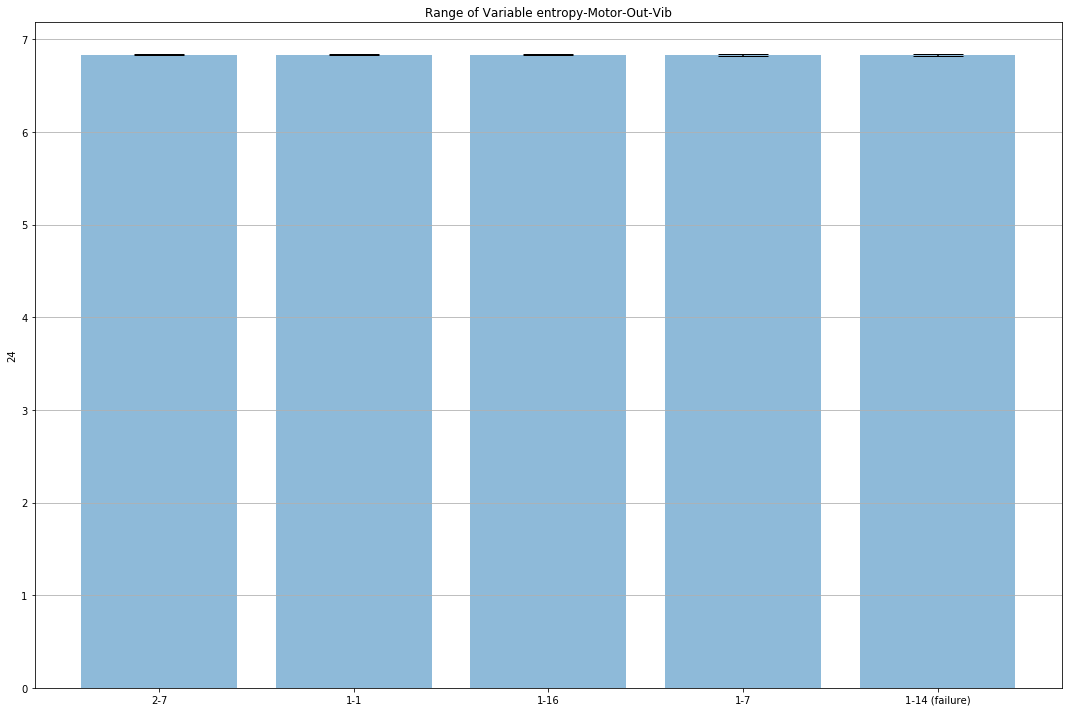

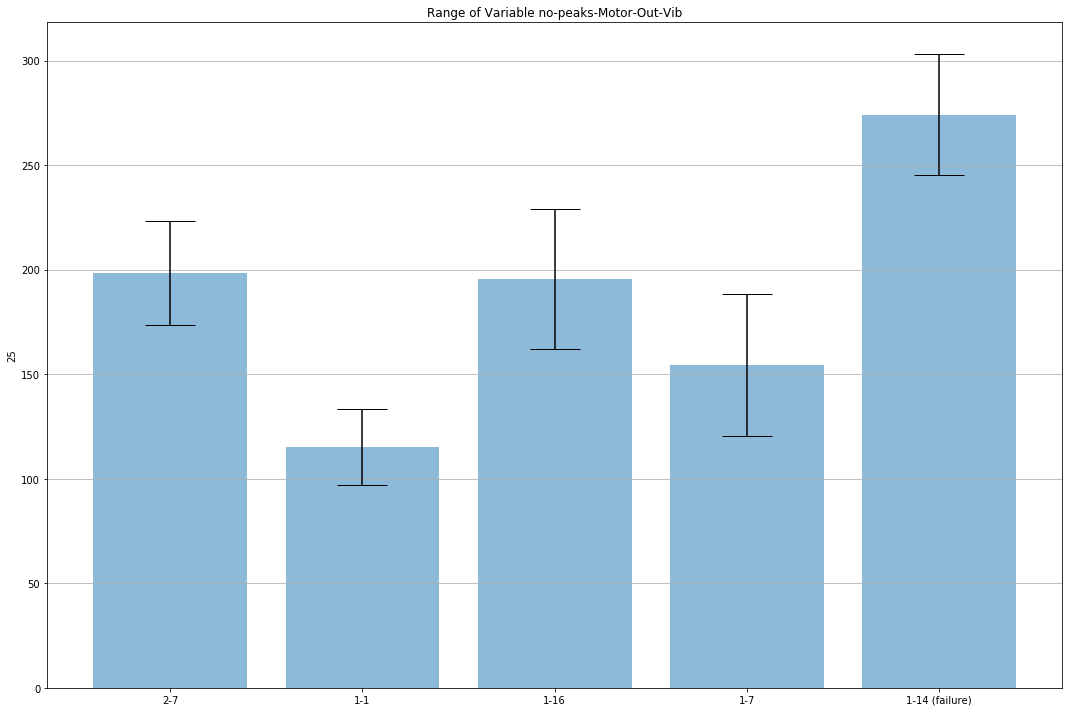

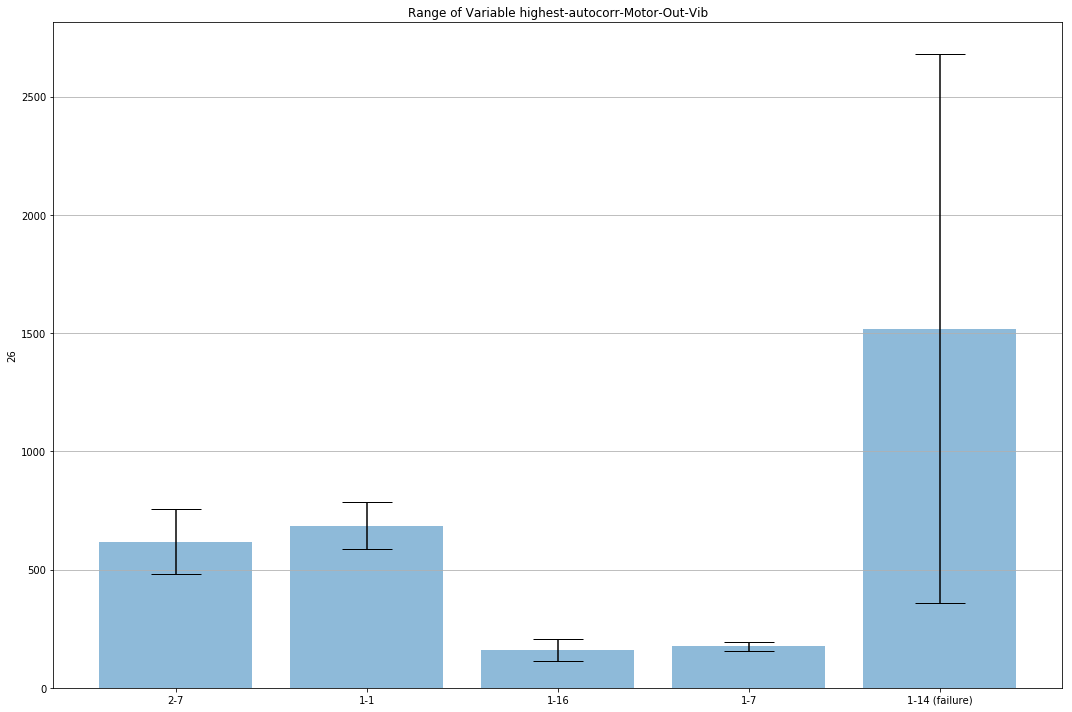

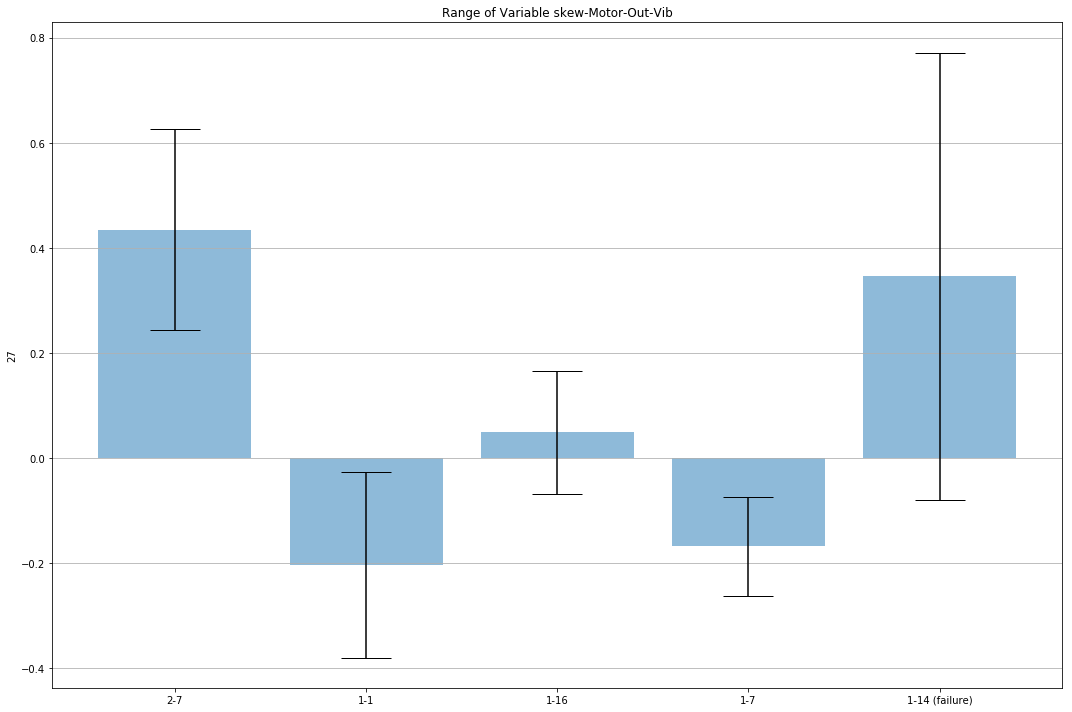

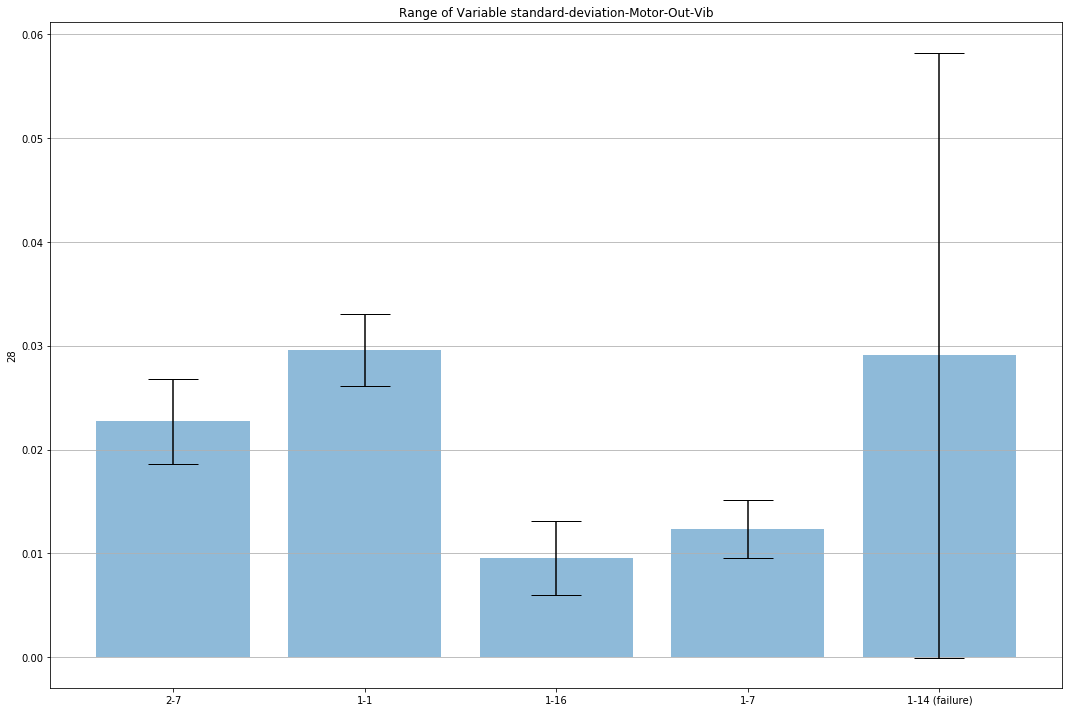

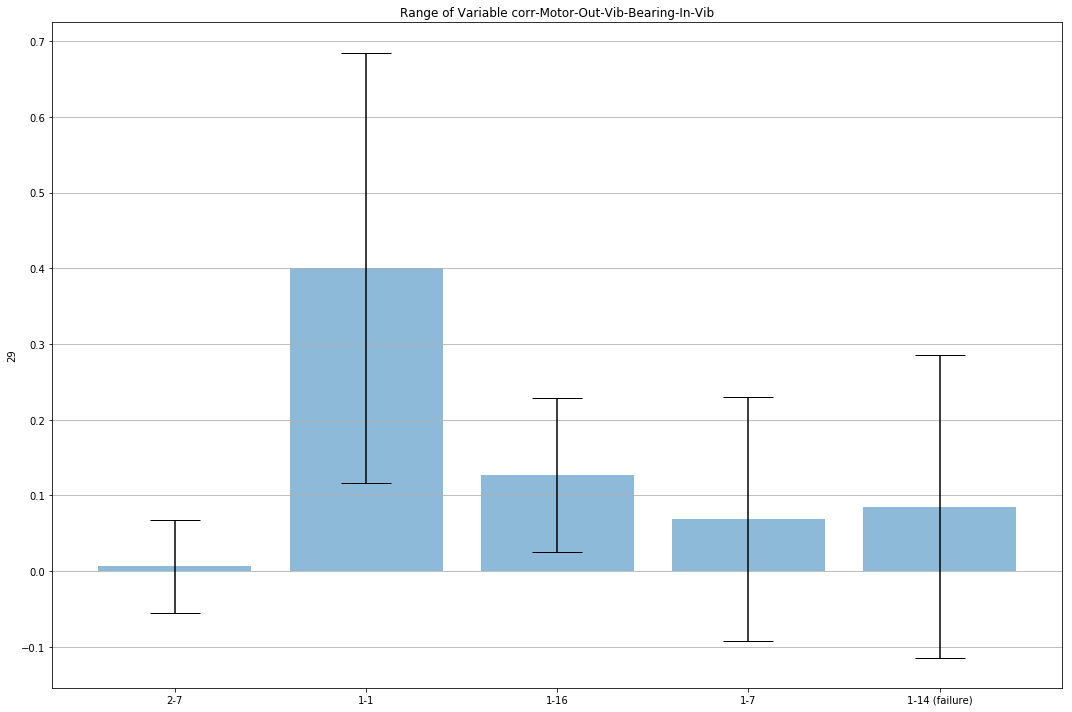

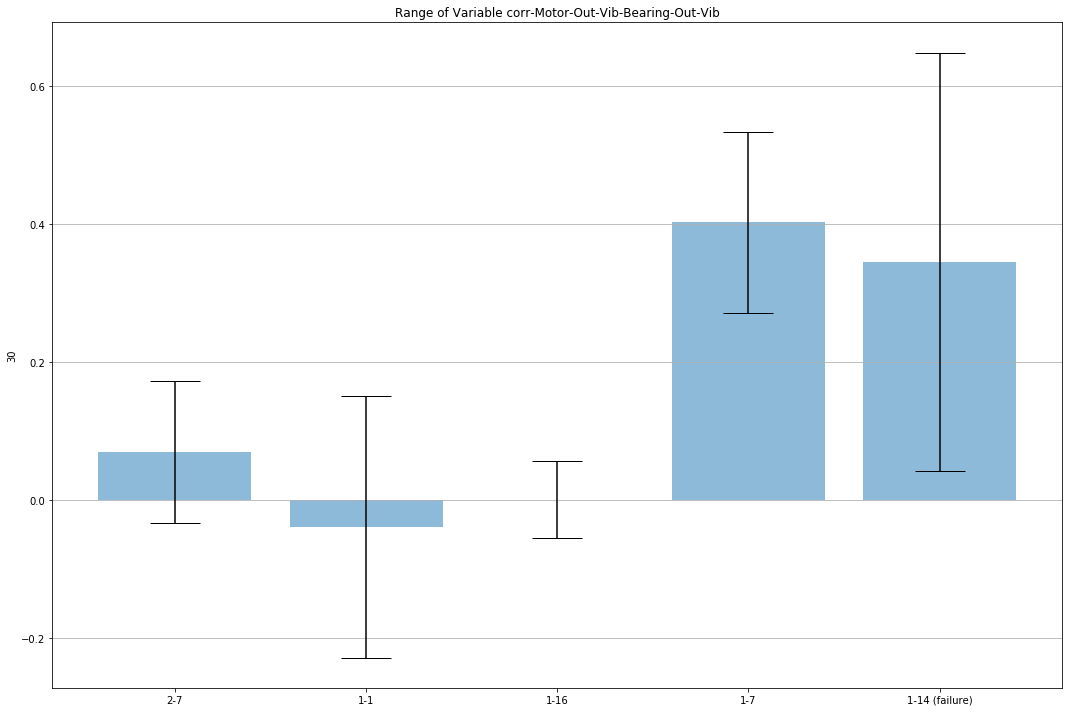

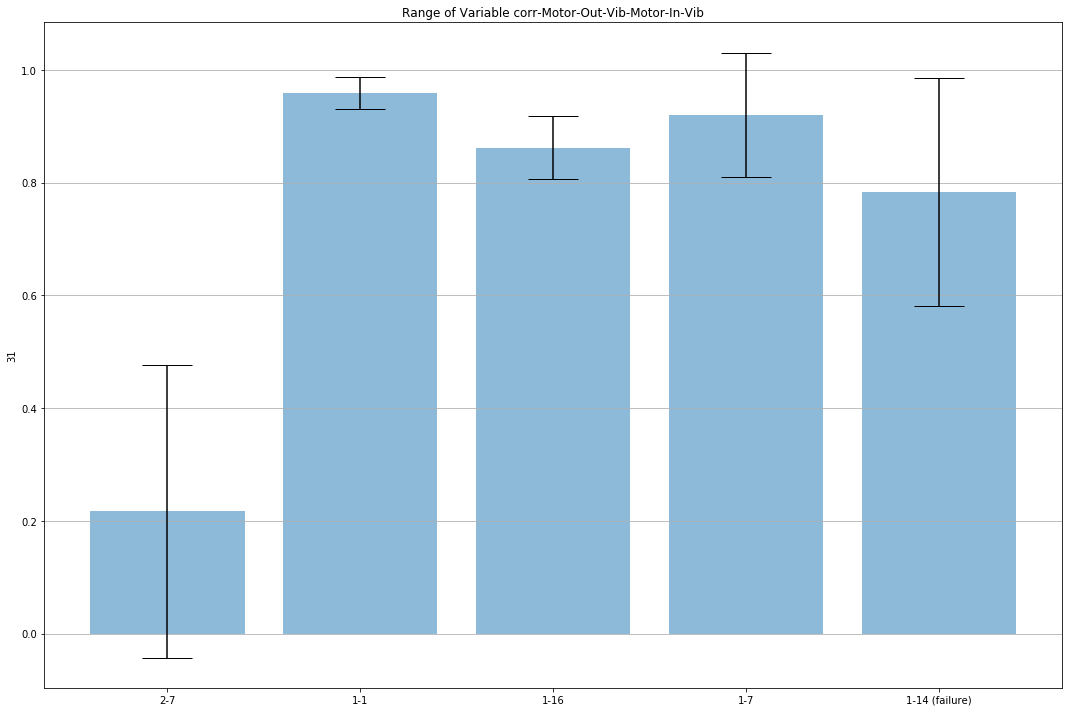

In [6]:
import seaborn as sns


dfs = [train, df1, df2, df3, df_failure]
dataset_labels = ['2-7', '1-1', '1-16', '1-7', '1-14 (failure)']

for col in range(0, train.shape[1]):
    plt.figure(figsize=(15,10))
    sns.distplot(train[:,col], color = 'blue', kde=False, label='2-7')
    sns.distplot(df1[:,col], color = 'green', kde=False, label='1-1')
    sns.distplot(df2[:,col], color = 'purple', kde=False, label='1-16')
    sns.distplot(df3[:,col], color = 'yellow', kde=False, label='1-7')
    sns.distplot(df_failure[:,col], color = 'red', kde=False, label='unhealthy')
    plt.legend()
    plt.xlabel('Range')
    plt.ylabel('Values')
    plt.title(lookup(col))
    plt.savefig('../figs/dist-'+lookup(col)+'.png')
        
    #plt.show()
    
for col in range(0, train.shape[1]):
    mean = [np.mean(d[:,col]) for d in dfs]
    error = [np.std(d[:,col]) for d in dfs]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.bar(np.arange(len(mean)), mean, yerr=error, align='center', alpha=0.5, 
                                ecolor='black', capsize=25)
    ax.set_ylabel(col)
    ax.set_xticks(np.arange(len(mean)))
    ax.set_xticklabels(dataset_labels)
    ax.set_title('Range of Variable ' + lookup(col))
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('../figs/' + 'bar-' + lookup(col) + str(col) + '.png')
        
    #plt.show()

In [103]:
sel = [14,15,5] # 2,3,4 #[0,1,2,3,4,14,15,16,17,20,22,24,25,28,30]
# standardize selected vars except for correlations

if False:
    sel_not_corr = [n for n in sel if "corr" not in lookup(n)]
    sel_corr = [n for n in sel if "corr" in lookup(n)]
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ntrain = sc.fit_transform(train[:,sel_not_corr])
    ndf1 = sc.transform(df1[:,sel_not_corr])
    ndf2 = sc.transform(df2[:,sel_not_corr])
    ndf3 = sc.transform(df3[:,sel_not_corr])
    ndf_failure = sc.transform(df_failure[:,sel_not_corr])

    train = np.concatenate((ntrain, train[:,sel]), axis=1)
    df1 = np.concatenate((ndf1, df1[:,sel]), axis=1)
    df2 = np.concatenate((ndf2, df2[:,sel]), axis=1)
    df3 = np.concatenate((ndf3, df3[:,sel]), axis=1)
    df_failure = np.concatenate((ndf_failure, df_failure[:,sel]), axis=1)
    
if True:
    train = train[:,sel]
    df1 = df1[:,sel]    
    df2 = df2[:,sel]    
    df3 = df3[:,sel]    
    df_failure = df_failure[:,sel]    

In [104]:
m = [9,7]

In [115]:
som = SOM(m = m,dim =  train.shape[1], n_iterations=50)
som.train(df_failure)

In [116]:
centroids = som.get_centroids()
print(centroids['[0 0]'])

[ 0.46537176  0.07982772 -0.06960546]


In [117]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
pca = PCA(n_components=3)
weights = np.zeros([m[0]*m[1], train.shape[1]])
i=0
keys = []
for key, val in centroids.items():
    keys.append(key) # need this for later
    weights[i] = val
    i+=1

colours = pca.fit_transform(weights)
sc = MinMaxScaler()
colours = sc.fit_transform(colours)

In [118]:
# Map inputs to their closest neurons
count = {key: 0 for key in keys}
mapped = som.map_vects(train)
for bmu in mapped:
    count[str(bmu)] += 1

list_count = [val for key, val in count.items()]
print(list_count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 27, 0, 0, 0, 0, 0, 0, 0, 48, 32, 15, 1, 0, 0, 0, 0, 0, 56, 106, 90, 3, 0, 0, 0, 0, 0, 37, 82, 199, 40, 1, 0, 0, 0, 0, 13, 56, 89, 22, 0, 0, 0, 0, 0]


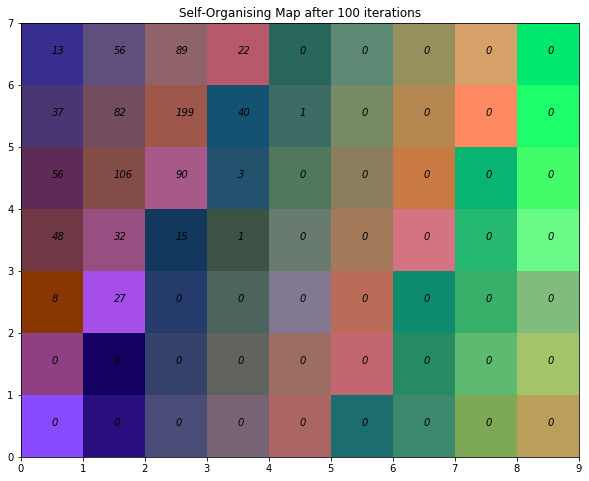

In [119]:
from matplotlib import patches as patches

# plot the rectangles
fig = plt.figure(figsize=(10,10))
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, m[0]))
ax.set_ylim((0, m[1]))
ax.set_title('Self-Organising Map after %d iterations' % 100)

i=0
for x in range(0, m[0]):
    for y in range(0, m[1]):
        ax.add_patch(patches.Rectangle((x, y), 1, 1,
                     facecolor=np.round(colours[i],2),
                     edgecolor='none'))
        ax.text(x+0.5, y+0.5, count[str(np.array([x, y]))], style='italic')
        i+=1

plt.savefig('../figs/som-colour-map.png')

plt.show()

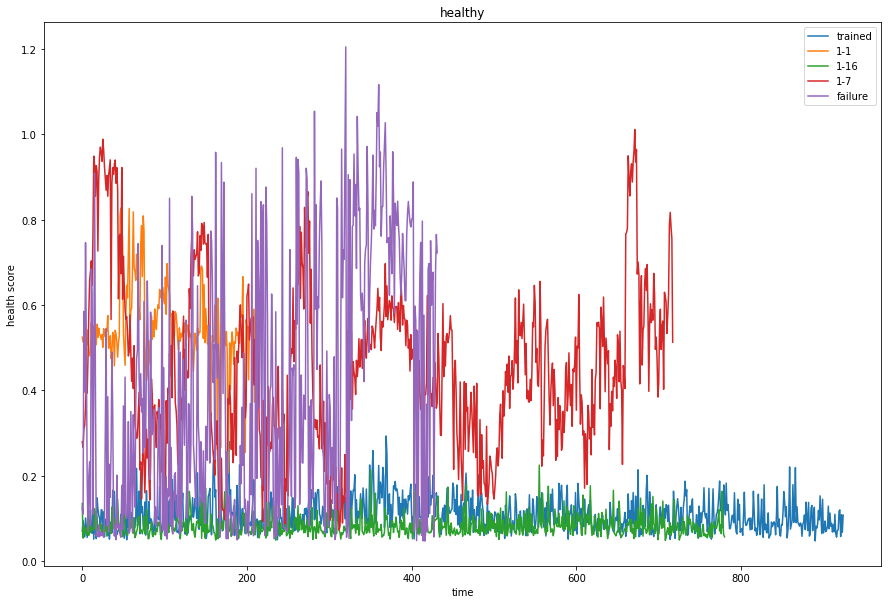

In [124]:
plt.figure(figsize=(15,10))
t=5

scores = som.health_score(train, 3, list_count, t)
plt.plot(scores, label = 'trained')

scores = som.health_score(df1, 3, list_count, t)
plt.plot(scores, label = '1-1')

scores = som.health_score(df2, 3, list_count, t)
plt.plot(scores, label = '1-16')

scores = som.health_score(df3, 3, list_count, t)
plt.plot(scores, label = '1-7')

scores = som.health_score(df_failure, 3, list_count, t)
plt.plot(scores, label = 'failure')

plt.xlabel('time')
plt.ylabel('health score')
plt.title('healthy')
plt.legend()
plt.savefig('../figs/health_score-raw.png')

plt.show()

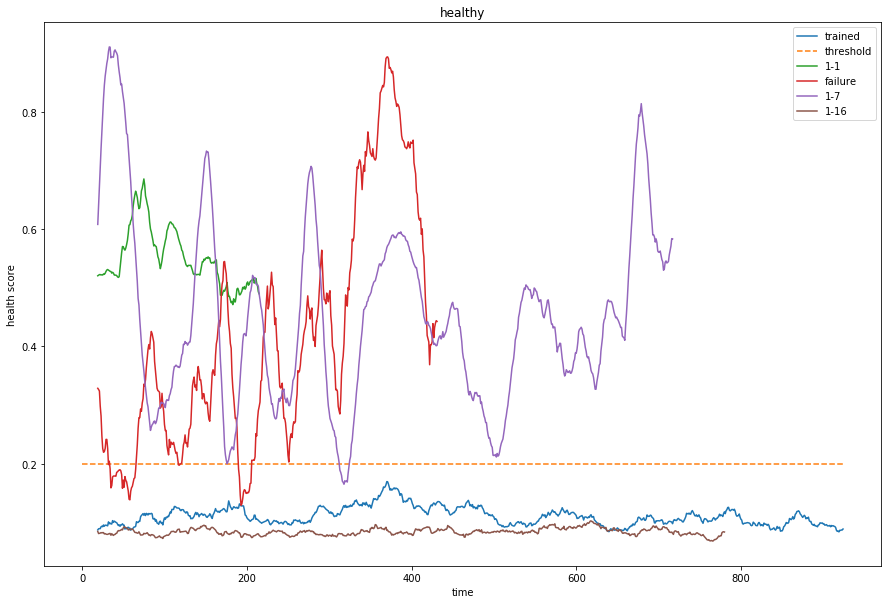

In [125]:
#from scipy.signal import savgol_filter
plt.figure(figsize=(15,10))

t=10

scores = pd.DataFrame(som.health_score(train, 3, list_count, t))
plt.plot(scores.rolling(window=20).mean(), label = 'trained')
plt.plot([0.2]*len(scores.index), linestyle='--', label = 'threshold')

scores = pd.DataFrame(som.health_score(df1, 3, list_count, t))
plt.plot(scores.rolling(window=20).mean(), label = '1-1')

scores = pd.DataFrame(som.health_score(df_failure, 3, list_count, t))
plt.plot(scores.rolling(window=20).mean(), label = 'failure')

scores = pd.DataFrame(som.health_score(df3, 3, list_count, t))
plt.plot(scores.rolling(window=20).mean(), label = '1-7')

scores = pd.DataFrame(som.health_score(df2, 3, list_count, t))
plt.plot(scores.rolling(window=20).mean(), label = '1-16')

plt.xlabel('time')
plt.ylabel('health score')
plt.title('healthy')
plt.legend()
plt.savefig('../figs/health_score-mov-avg.png')
plt.show()

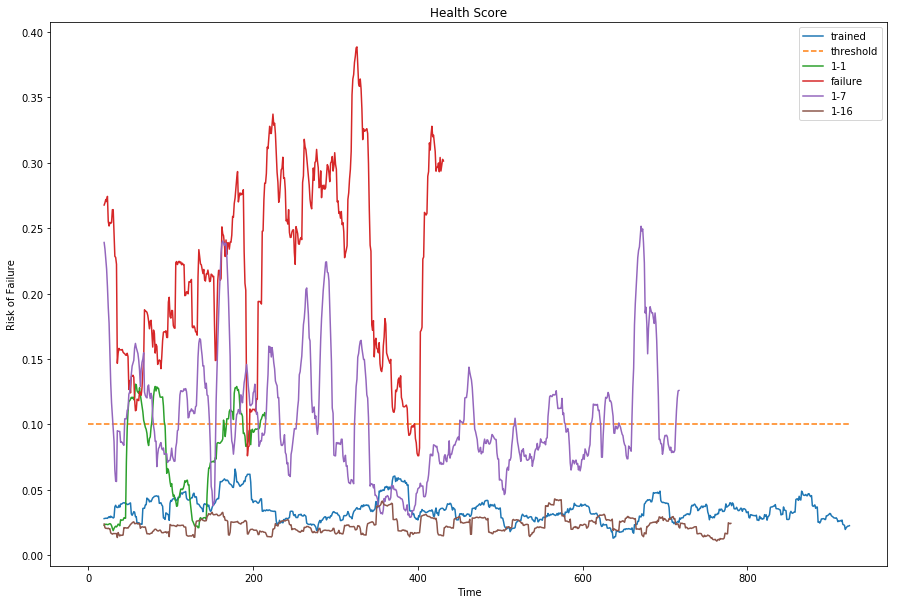

In [122]:
plt.figure(figsize=(15,10))

t = 5

scores = pd.DataFrame(som.health_score(train, 3, list_count, t))
plt.plot(scores.rolling(window=20).std(), label = 'trained')

plt.plot([0.1]*len(scores.index), linestyle='--', label = 'threshold')

scores = pd.DataFrame(som.health_score(df1, 3, list_count, t))
plt.plot(scores.rolling(window=20).std(), label = '1-1')

scores = pd.DataFrame(som.health_score(df_failure, 3, list_count, t))
plt.plot(scores.rolling(window=20).std(), label = 'failure')

scores = pd.DataFrame(som.health_score(df3, 3, list_count, t))
plt.plot(scores.rolling(window=20).std(), label = '1-7')

scores = pd.DataFrame(som.health_score(df2, 3, list_count, t))
plt.plot(scores.rolling(window=20).std(), label = '1-16')




plt.xlabel('Time')
plt.ylabel('Risk of Failure')
plt.title('Health Score')
plt.legend()
plt.savefig('../figs/health_score-std.png')
plt.show()

In [123]:
for variable in sel:
    print(lookup(variable))

corr-Bearing-Out-Vib-Motor-In-Vib
corr-Bearing-Out-Vib-Motor-Out-Vib
corr-Bearing-In-Vib-Bearing-Out-Vib
